# Estrategia de Cobertura del SPY con Opciones PUT TRIMESTRALES

## Objetivo
Este notebook implementa y analiza una estrategia de inversión que combina:
- **Inversión principal**: 100% del capital en SPY (ETF del S&P 500)
- **Cobertura**: Compra de opciones PUT **trimestrales** (3 meses) 10% OTM

## Hipótesis
Las PUTs trimestrales ofrecen:
1. **Menor coste de transacción**: Solo ~4 renovaciones/año vs ~12 mensuales
2. **Primas más eficientes**: Mejor theta decay por día
3. **Protección continua**: Cobertura ininterrumpida por todo el trimestre

## Estrategia
- **Strike de la PUT**: 10% por debajo del precio actual del SPY
- **Vencimiento**: 90 días (3 meses - renovación trimestral)
- **Valoración**: Modelo Black-Scholes con ajustes conservadores
- **Cobertura**: 100% del capital invertido
- **Renovación**: Al inicio de cada trimestre (Ene, Abr, Jul, Oct)

## 1. Configuración e Importación de Librerías

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [2]:
# Parámetros de la estrategia TRIMESTRAL
INITIAL_CAPITAL = 100000  # Capital inicial
OTM_PERCENT = 0.10  # Strike 10% por debajo del precio actual
DAYS_TO_EXPIRY = 90  # Vencimiento de las PUT en días (3 meses = trimestre)
VOLATILITY_SKEW_ADJUSTMENT = 1.20  # Ajuste conservador: +20% a la volatilidad
TRANSACTION_COST_PCT = 0.001  # 0.1% por operación de opciones
VOLATILITY_WINDOW = 60  # Ventana para calcular volatilidad histórica (2 meses)

# Fechas del backtest
START_DATE = "2002-01-01"  # Inicio en 2002 como solicitado
END_DATE = datetime.now().strftime("%Y-%m-%d")

print(f"Parámetros de la estrategia TRIMESTRAL:")
print(f"  - Capital inicial: ${INITIAL_CAPITAL:,.0f}")
print(f"  - Strike PUT: {OTM_PERCENT*100:.0f}% OTM")
print(f"  - Vencimiento: {DAYS_TO_EXPIRY} días (3 meses)")
print(f"  - Renovación: TRIMESTRAL (Ene, Abr, Jul, Oct)")
print(f"  - Ajuste volatilidad: +{(VOLATILITY_SKEW_ADJUSTMENT-1)*100:.0f}%")
print(f"  - Costes transacción: {TRANSACTION_COST_PCT*100:.1f}%")
print(f"  - Período: {START_DATE} a {END_DATE} (~23 años de datos)")


Parámetros de la estrategia TRIMESTRAL:
  - Capital inicial: $100,000
  - Strike PUT: 10% OTM
  - Vencimiento: 90 días (3 meses)
  - Renovación: TRIMESTRAL (Ene, Abr, Jul, Oct)
  - Ajuste volatilidad: +20%
  - Costes transacción: 0.1%
  - Período: 2002-01-01 a 2025-10-31 (~23 años de datos)


## 2. Descarga de Datos Históricos del SPY

In [3]:
# Descargar datos de SPY
print(f"Descargando datos de SPY desde {START_DATE} hasta {END_DATE}...")
spy = yf.Ticker("SPY")
spy_data = spy.history(start=START_DATE, end=END_DATE)

# Limpiar datos
spy_data = spy_data[['Close']].copy()
spy_data.columns = ['price']
spy_data = spy_data.dropna()

# Calcular retornos diarios
spy_data['returns'] = spy_data['price'].pct_change()

# Calcular volatilidad histórica (anualizada, ventana móvil)
spy_data['volatility'] = spy_data['returns'].rolling(window=VOLATILITY_WINDOW).std() * np.sqrt(252)

# Eliminar NaN iniciales
spy_data = spy_data.dropna()

print(f"\n✓ Datos descargados: {len(spy_data)} días de trading")
print(f"  Rango: {spy_data.index[0].strftime('%Y-%m-%d')} a {spy_data.index[-1].strftime('%Y-%m-%d')}")
print(f"\nEstadísticas del SPY:")
print(f"  Precio promedio: ${spy_data['price'].mean():.2f}")
print(f"  Volatilidad promedio: {spy_data['volatility'].mean()*100:.2f}%")
print(f"  Retorno total: {((spy_data['price'].iloc[-1] / spy_data['price'].iloc[0]) - 1) * 100:.2f}%")

spy_data.head()

$SPY: possibly delisted; no price data found  (1d 2002-01-01 -> 2025-10-31)


Descargando datos de SPY desde 2002-01-01 hasta 2025-10-31...


ValueError: attempt to get argmax of an empty sequence

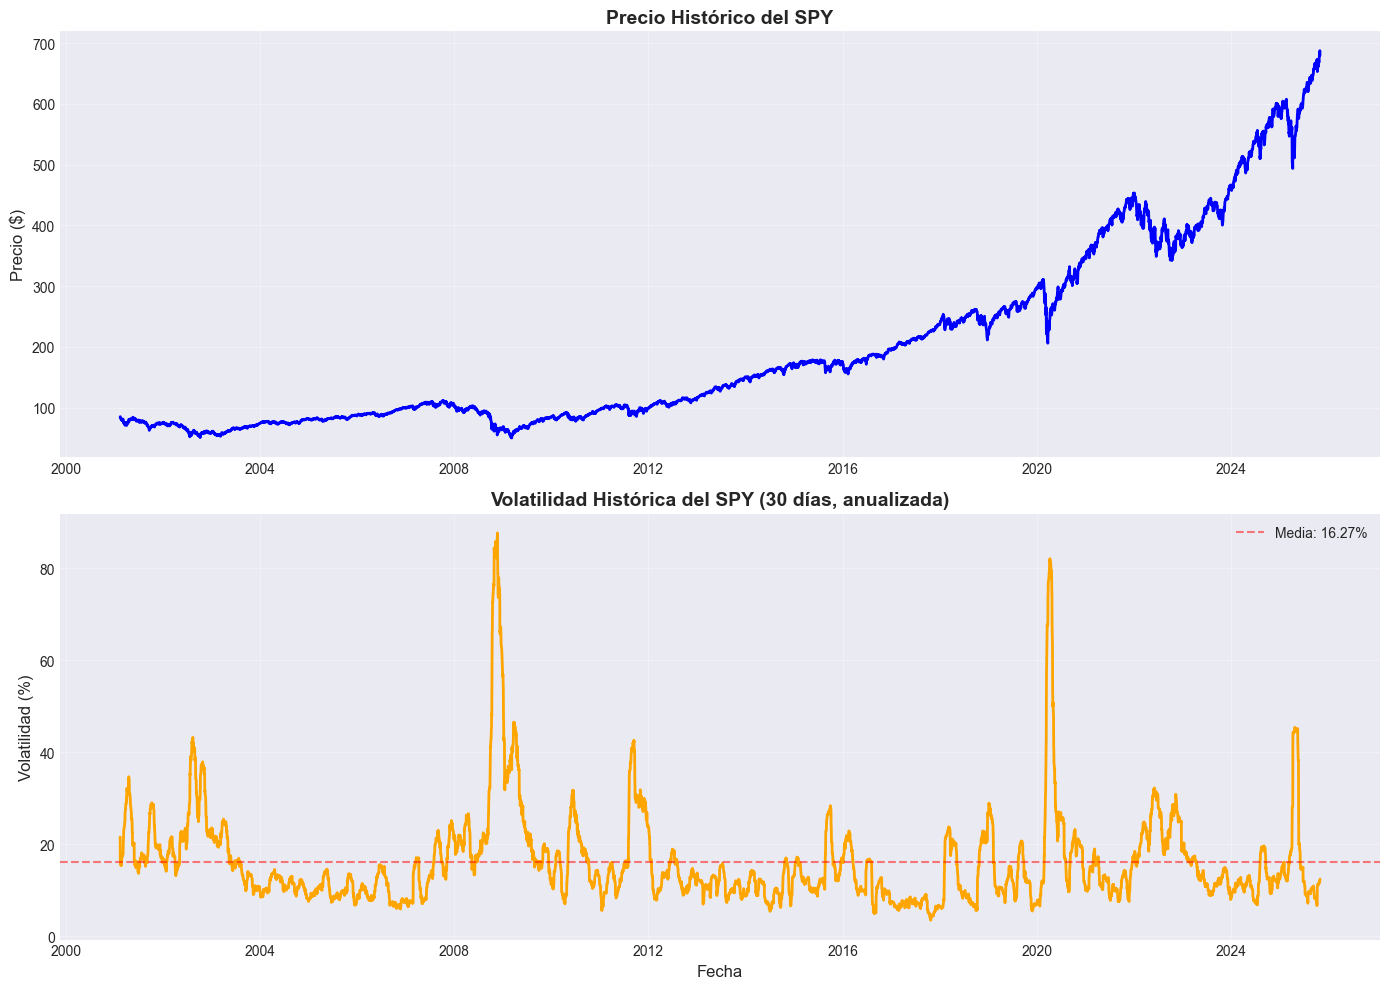

In [ ]:
# Visualizar precio y volatilidad del SPY
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Precio
axes[0].plot(spy_data.index, spy_data['price'], linewidth=2, color='blue')
axes[0].set_title('Precio Histórico del SPY', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precio ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Volatilidad
axes[1].plot(spy_data.index, spy_data['volatility'] * 100, linewidth=2, color='orange')
axes[1].axhline(y=spy_data['volatility'].mean() * 100, color='red', linestyle='--', alpha=0.5, 
                label=f'Media: {spy_data["volatility"].mean()*100:.2f}%')
axes[1].set_title('Volatilidad Histórica del SPY (30 días, anualizada)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatilidad (%)', fontsize=12)
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Descarga de Tasa Libre de Riesgo (Treasury Bill 3 meses)

In [ ]:
# Descargar tasa libre de riesgo (Treasury Bill 3 meses)
print("Descargando tasa libre de riesgo (^IRX - Treasury Bill 3M)...")
try:
    irx = yf.Ticker("^IRX")
    irx_data = irx.history(start=START_DATE, end=END_DATE)
    
    # Usar precio de cierre y convertir a tasa decimal
    risk_free_rate = irx_data[['Close']].copy()
    risk_free_rate.columns = ['rate']
    risk_free_rate['rate'] = risk_free_rate['rate'] / 100  # Convertir de % a decimal
    
    # Forward fill para llenar días sin datos (fines de semana, festivos)
    risk_free_rate = risk_free_rate.reindex(spy_data.index, method='ffill')
    
    # Si hay NaN al inicio, backfill
    risk_free_rate = risk_free_rate.fillna(method='bfill')
    
    # Si aún hay NaN, usar valor por defecto (3%)
    risk_free_rate = risk_free_rate.fillna(0.03)
    
    print(f"✓ Tasa libre de riesgo descargada")
    print(f"  Tasa promedio: {risk_free_rate['rate'].mean()*100:.2f}%")
    print(f"  Tasa mínima: {risk_free_rate['rate'].min()*100:.2f}%")
    print(f"  Tasa máxima: {risk_free_rate['rate'].max()*100:.2f}%")
    
except Exception as e:
    print(f"⚠ Error descargando ^IRX: {e}")
    print("  Usando tasa fija del 3% como fallback")
    risk_free_rate = pd.DataFrame({'rate': 0.03}, index=spy_data.index)

# Combinar con datos de SPY
spy_data['risk_free_rate'] = risk_free_rate['rate']

Descargando tasa libre de riesgo (^IRX - Treasury Bill 3M)...


✓ Tasa libre de riesgo descargada
  Tasa promedio: 1.69%
  Tasa mínima: -0.10%
  Tasa máxima: 5.35%


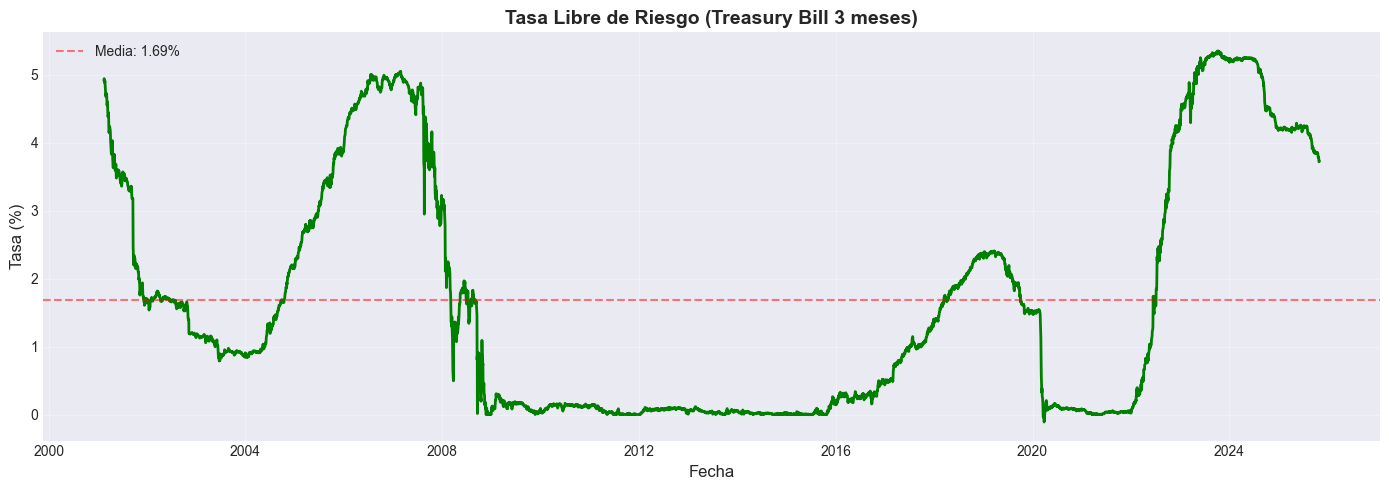

In [ ]:
# Visualizar evolución de la tasa libre de riesgo
plt.figure(figsize=(14, 5))
plt.plot(spy_data.index, spy_data['risk_free_rate'] * 100, linewidth=2, color='green')
plt.axhline(y=spy_data['risk_free_rate'].mean() * 100, color='red', linestyle='--', alpha=0.5,
            label=f'Media: {spy_data["risk_free_rate"].mean()*100:.2f}%')
plt.title('Tasa Libre de Riesgo (Treasury Bill 3 meses)', fontsize=14, fontweight='bold')
plt.ylabel('Tasa (%)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Implementación del Modelo Black-Scholes para Opciones PUT

In [ ]:
def black_scholes_put(S, K, T, r, sigma):
    """
    Calcula el precio teórico de una opción PUT europea usando Black-Scholes.
    
    Parámetros:
    -----------
    S : float
        Precio actual del subyacente
    K : float
        Precio de ejercicio (strike)
    T : float
        Tiempo hasta vencimiento en años
    r : float
        Tasa libre de riesgo anual (decimal)
    sigma : float
        Volatilidad anual (decimal)
    
    Retorna:
    --------
    float : Precio de la opción PUT
    """
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(K - S, 0)  # Valor intrínseco si hay parámetros inválidos
    
    # Calcular d1 y d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calcular precio de PUT usando Black-Scholes
    # PUT = K * e^(-rT) * N(-d2) - S * N(-d1)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return put_price


def calculate_put_value(S, K, T, r, sigma):
    """
    Calcula el valor actual de una PUT (antes del vencimiento usa Black-Scholes,
    al vencimiento usa valor intrínseco).
    """
    if T <= 0:
        # Al vencimiento: valor intrínseco
        return max(K - S, 0)
    else:
        # Antes del vencimiento: Black-Scholes
        return black_scholes_put(S, K, T, r, sigma)


# Prueba del modelo
print("Prueba del modelo Black-Scholes:")
print("="*50)
test_S = 400  # Precio SPY
test_K = 360  # Strike 10% OTM
test_T = 30/365  # 30 días
test_r = 0.04  # 4% anual
test_sigma = 0.18  # 18% volatilidad

test_price = black_scholes_put(test_S, test_K, test_T, test_r, test_sigma)
test_price_adjusted = black_scholes_put(test_S, test_K, test_T, test_r, test_sigma * VOLATILITY_SKEW_ADJUSTMENT)

print(f"Precio SPY: ${test_S}")
print(f"Strike PUT: ${test_K} ({((test_K/test_S - 1)*100):.1f}% OTM)")
print(f"Días hasta vencimiento: 30")
print(f"Tasa libre riesgo: {test_r*100:.1f}%")
print(f"Volatilidad: {test_sigma*100:.1f}%")
print(f"\nPrecio PUT (Black-Scholes estándar): ${test_price:.2f} ({test_price/test_S*100:.2f}% del precio)")
print(f"Precio PUT (ajustado +20% vol): ${test_price_adjusted:.2f} ({test_price_adjusted/test_S*100:.2f}% del precio)")
print(f"\n✓ Modelo Black-Scholes implementado correctamente")

Prueba del modelo Black-Scholes:
Precio SPY: $400
Strike PUT: $360 (-10.0% OTM)
Días hasta vencimiento: 30
Tasa libre riesgo: 4.0%
Volatilidad: 18.0%

Precio PUT (Black-Scholes estándar): $0.12 (0.03% del precio)
Precio PUT (ajustado +20% vol): $0.38 (0.09% del precio)

✓ Modelo Black-Scholes implementado correctamente


## 5. Implementación de la Estrategia con Cobertura PUT

In [ ]:
class ProtectedSPYStrategy:
    """
    Estrategia de inversión en SPY con cobertura mediante opciones PUT.
    """
    
    def __init__(self, data, initial_capital, otm_percent, days_to_expiry, 
                 vol_adjustment, transaction_cost_pct):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.otm_percent = otm_percent
        self.days_to_expiry = days_to_expiry
        self.vol_adjustment = vol_adjustment
        self.transaction_cost_pct = transaction_cost_pct
        
        # Estado del portafolio
        self.cash = initial_capital  # Empezamos con todo en cash
        self.spy_shares = 0
        self.current_put = None  # {'strike', 'expiry_date', 'shares', 'buy_date'}
        
        # Tracking (solo para estadísticas, no afectan al valor del portafolio)
        self.portfolio_values = []
        self.total_premiums_paid = 0  # Tracking: suma de todas las primas pagadas
        self.total_put_gains = 0  # Tracking: suma de todos los payouts de PUT
        self.put_renewals = []
        self.transaction_costs = 0  # Tracking: suma de todos los costes
        
    def buy_spy(self, price):
        """Compra acciones de SPY con TODO el cash disponible."""
        if self.cash <= 0:
            return 0
        shares = self.cash / price
        self.spy_shares = shares
        self.cash = 0
        return shares
    
    def buy_put(self, date, spy_price, volatility, risk_free_rate):
        """Compra una opción PUT de cobertura. PAGA la prima restándola del cash."""
        # Definir strike y vencimiento
        strike = spy_price * (1 - self.otm_percent)
        
        # Vencimiento: último día del mes siguiente
        # Normalizar fecha para evitar problemas de timezone
        date_normalized = pd.Timestamp(date.year, date.month, date.day)
        
        if date_normalized.month == 12:
            expiry_date = pd.Timestamp(year=date_normalized.year + 1, month=1, day=1) - timedelta(days=1)
        else:
            expiry_date = pd.Timestamp(year=date_normalized.year, month=date_normalized.month + 1, day=1) - timedelta(days=1)
        
        # Calcular días reales hasta vencimiento
        days_until_expiry = (expiry_date - date_normalized).days
        time_to_expiry = max(days_until_expiry / 365, 1/365)  # Mínimo 1 día
        
        # Ajustar volatilidad (conservador: +20%)
        adjusted_vol = volatility * self.vol_adjustment
        
        # Calcular precio de la PUT usando Black-Scholes
        put_price_per_share = black_scholes_put(spy_price, strike, time_to_expiry, 
                                                 risk_free_rate, adjusted_vol)
        
        # Comprar PUTs para todas las acciones (cobertura 100%)
        total_premium = put_price_per_share * self.spy_shares
        
        # Costes de transacción
        transaction_cost = total_premium * self.transaction_cost_pct
        total_cost = total_premium + transaction_cost
        
        # PAGAR la prima: restar del cash
        self.cash -= total_cost
        
        # Registrar PUT actual (solo lo necesario para valoración)
        self.current_put = {
            'strike': strike,
            'expiry_date': expiry_date,
            'shares': self.spy_shares,
            'buy_date': date
        }
        
        # Actualizar variables de tracking (solo estadísticas)
        self.total_premiums_paid += total_premium
        self.transaction_costs += transaction_cost
        
        # Registrar renovación para análisis
        self.put_renewals.append({
            'date': date,
            'spy_price': spy_price,
            'strike': strike,
            'premium': total_premium,
            'transaction_cost': transaction_cost,
            'volatility': adjusted_vol
        })
        
        return total_cost
    
    def get_put_value(self, date, spy_price, volatility, risk_free_rate):
        """Calcula el valor actual de la PUT."""
        if self.current_put is None:
            return 0
        
        # Normalizar fecha para comparación
        date_normalized = pd.Timestamp(date.year, date.month, date.day)
        
        # Calcular tiempo hasta vencimiento
        days_remaining = (self.current_put['expiry_date'] - date_normalized).days
        time_to_expiry = max(days_remaining / 365, 0)
        
        # Ajustar volatilidad
        adjusted_vol = volatility * self.vol_adjustment
        
        # Valor de la PUT
        put_value_per_share = calculate_put_value(
            spy_price, 
            self.current_put['strike'], 
            time_to_expiry, 
            risk_free_rate, 
            adjusted_vol
        )
        
        return put_value_per_share * self.current_put['shares']
    
    def check_expiry_and_renew(self, date, spy_price, volatility, risk_free_rate):
        """Verifica si la PUT trimestral ha expirado y la renueva."""
        if self.current_put is None:
            return
        
        # Normalizar fecha para comparación
        date_normalized = pd.Timestamp(date.year, date.month, date.day)
        
        # RENOVACIÓN AUTOMÁTICA: Las PUTs de 90 días expiran naturalmente cada trimestre
        if date_normalized >= self.current_put['expiry_date']:
            # Calcular payout de la PUT al vencimiento (valor intrínseco)
            strike = self.current_put['strike']
            shares = self.current_put['shares']
            intrinsic_value = max(strike - spy_price, 0)
            total_payout = intrinsic_value * shares
            
            # DEBUG: Mostrar cuando hay payouts significativos (>$1000)
            if total_payout > 1000:
                spy_drop_pct = ((spy_price / (strike / 0.9)) - 1) * 100  # Calcular caída desde inicio mes
                print(f"\n  🔔 PUT PAYOUT: {date.strftime('%Y-%m-%d')}")
                print(f"     Strike: ${strike:.2f}, SPY: ${spy_price:.2f}, Caída SPY: {spy_drop_pct:.1f}%")
                print(f"     Payout: ${total_payout:,.0f} ({intrinsic_value:.2f} por acción x {shares:.0f} acciones)")
            
            # Si hay payout, REINVERTIR en SPY (comprar más acciones)
            if total_payout > 0:
                self.cash += total_payout
                self.total_put_gains += total_payout  # Tracking
                
                # Reinvertir el payout en SPY
                additional_shares = self.cash / spy_price
                self.spy_shares += additional_shares
                
                if total_payout > 1000:
                    print(f"     Reinvertidas {additional_shares:.2f} acciones a ${spy_price:.2f}")
                    print(f"     Total acciones ahora: {self.spy_shares:.2f}")
                
                self.cash = 0
            
            # Renovar PUT (esto restará la nueva prima del cash, quedará negativo)
            self.current_put = None
            self.buy_put(date, spy_price, volatility, risk_free_rate)
    
    def get_portfolio_value(self, date, spy_price, volatility, risk_free_rate):
        """Calcula el valor total del portafolio."""
        spy_value = self.spy_shares * spy_price
        put_value = self.get_put_value(date, spy_price, volatility, risk_free_rate)
        
        # CORRECCIÓN FINAL: El valor del portafolio es simplemente lo que tienes AHORA
        # Las primas ya se pagaron (salieron del cash), los payouts ya entraron al cash
        total_value = spy_value + put_value + self.cash
        
        return total_value
    
    def run(self):
        """Ejecuta el backtest de la estrategia."""
        print("Ejecutando estrategia con cobertura PUT...\n")
        
        # Inicializar en el primer día
        first_date = self.data.index[0]
        first_price = self.data.iloc[0]['price']
        first_vol = self.data.iloc[0]['volatility']
        first_rf = self.data.iloc[0]['risk_free_rate']
        
        # Comprar SPY con TODO el capital inicial (cash quedará en 0)
        self.buy_spy(first_price)
        spy_investment = self.spy_shares * first_price
        
        # Comprar primera PUT (se pagará con "crédito" ya que cash=0)
        # Esto representa que el inversor usa margen o tiene crédito para las primas
        put_cost = self.buy_put(first_date, first_price, first_vol, first_rf)
        
        print(f"Inicio: {first_date.strftime('%Y-%m-%d')}")
        print(f"  Capital inicial: ${self.initial_capital:,.2f}")
        print(f"  Invertido en SPY: ${spy_investment:,.2f} ({self.spy_shares:.2f} acciones a ${first_price:.2f})")
        print(f"  Prima PUT pagada: ${put_cost:,.2f}")
        print(f"  Cash restante: ${self.cash:,.2f}")
        print(f"  Valor inicial portafolio: ${self.get_portfolio_value(first_date, first_price, first_vol, first_rf):,.2f}\n")
        
        # Iterar día a día, pero solo renovar PUT al inicio de cada trimestre
        for date, row in self.data.iterrows():
            spy_price = row['price']
            volatility = row['volatility']
            risk_free_rate = row['risk_free_rate']
            
            # Verificar y renovar PUT si ha expirado o si estamos al inicio de un nuevo trimestre
            self.check_expiry_and_renew(date, spy_price, volatility, risk_free_rate)
            
            # Calcular y guardar valor del portafolio DIARIAMENTE
            portfolio_value = self.get_portfolio_value(date, spy_price, volatility, risk_free_rate)
            
            self.portfolio_values.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'spy_value': self.spy_shares * spy_price,
                'put_value': self.get_put_value(date, spy_price, volatility, risk_free_rate),
                'cash': self.cash,
                'spy_shares': self.spy_shares
            })
        
        print(f"✓ Backtest completado")
        print(f"  Total de renovaciones de PUT: {len(self.put_renewals)}")
        print(f"  Primas totales pagadas: ${self.total_premiums_paid:,.2f}")
        print(f"  Ganancias totales de PUT: ${self.total_put_gains:,.2f}")
        print(f"  Coste neto de cobertura: ${(self.total_premiums_paid - self.total_put_gains):,.2f}")
        print(f"  Costes de transacción: ${self.transaction_costs:,.2f}")
        
        final_value = self.portfolio_values[-1]['portfolio_value']
        total_return = (final_value / self.initial_capital - 1) * 100
        print(f"\n  Valor final: ${final_value:,.2f}")
        print(f"  Retorno total: {total_return:.2f}%")

## 6. Implementación de la Estrategia Buy & Hold (sin cobertura)

In [ ]:
class BuyAndHoldSPY:
    """
    Estrategia simple de comprar y mantener SPY (sin cobertura).
    """
    
    def __init__(self, data, initial_capital):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.spy_shares = 0
        self.portfolio_values = []
    
    def run(self):
        """Ejecuta el backtest de buy & hold."""
        print("Ejecutando estrategia Buy & Hold (sin cobertura)...\n")
        
        # Comprar SPY en el primer día
        first_price = self.data.iloc[0]['price']
        self.spy_shares = self.initial_capital / first_price
        
        print(f"Inicio: {self.data.index[0].strftime('%Y-%m-%d')}")
        print(f"  Acciones SPY compradas: {self.spy_shares:.2f} a ${first_price:.2f}")
        print(f"  Capital invertido: ${self.initial_capital:,.2f}\n")
        
        # Calcular valor diario
        for date, row in self.data.iterrows():
            spy_price = row['price']
            portfolio_value = self.spy_shares * spy_price
            
            self.portfolio_values.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'spy_value': portfolio_value,
                'put_value': 0,
                'cash': 0,
                'spy_shares': self.spy_shares
            })
        
        final_value = self.portfolio_values[-1]['portfolio_value']
        total_return = (final_value / self.initial_capital - 1) * 100
        
        print(f"✓ Backtest completado")
        print(f"  Valor final: ${final_value:,.2f}")
        print(f"  Retorno total: {total_return:.2f}%")


## 7. Ejecución de Ambas Estrategias

In [ ]:
# Estrategia 1: SPY con cobertura PUT
protected_strategy = ProtectedSPYStrategy(
    data=spy_data,
    initial_capital=INITIAL_CAPITAL,
    otm_percent=OTM_PERCENT,
    days_to_expiry=DAYS_TO_EXPIRY,
    vol_adjustment=VOLATILITY_SKEW_ADJUSTMENT,
    transaction_cost_pct=TRANSACTION_COST_PCT
)
protected_strategy.run()

Ejecutando estrategia con cobertura PUT...

Inicio: 2001-02-14
  Capital inicial: $100,000.00
  Invertido en SPY: $100,000.00 (1186.05 acciones a $84.31)
  Prima PUT pagada: $30.17
  Cash restante: $-30.17
  Valor inicial portafolio: $99,999.97


  🔔 PUT PAYOUT: 2008-10-31
     Strike: $76.20, SPY: $70.64, Caída SPY: -16.6%
     Payout: $6,597 (5.56 por acción x 1186 acciones)
     Reinvertidas -76.98 acciones a $70.64
     Total acciones ahora: 1109.07

  🔔 PUT PAYOUT: 2008-12-01
     Strike: $63.76, SPY: $59.90, Caída SPY: -15.4%
     Payout: $4,279 (3.86 por acción x 1109 acciones)
     Reinvertidas -7.29 acciones a $59.90
     Total acciones ahora: 1101.78



  🔔 PUT PAYOUT: 2009-03-02


     Strike: $54.66, SPY: $51.92, Caída SPY: -14.5%
     Payout: $2,766 (2.74 por acción x 1010 acciones)
     Reinvertidas 42.95 acciones a $51.92
     Total acciones ahora: 1053.42

  🔔 PUT PAYOUT: 2020-03-31
     Strike: $255.67, SPY: $238.28, Caída SPY: -16.1%
     Payout: $17,520 (17.38 por acción x 1008 acciones)
     Reinvertidas 11.22 acciones a $238.28
     Total acciones ahora: 1019.01
✓ Backtest completado
  Total de renovaciones de PUT: 506
  Primas totales pagadas: $100,565.06
  Ganancias totales de PUT: $32,665.34
  Coste neto de cobertura: $67,899.72
  Costes de transacción: $100.57

  Valor final: $634,974.56
  Retorno total: 534.97%


In [ ]:
print("\n" + "="*70 + "\n")

# Estrategia 2: Buy & Hold sin cobertura
buy_hold_strategy = BuyAndHoldSPY(
    data=spy_data,
    initial_capital=INITIAL_CAPITAL
)
buy_hold_strategy.run()



Ejecutando estrategia Buy & Hold (sin cobertura)...

Inicio: 2001-02-14
  Acciones SPY compradas: 1186.05 a $84.31
  Capital invertido: $100,000.00

✓ Backtest completado
  Valor final: $806,314.08
  Retorno total: 706.31%


In [ ]:
# =============================================================================
# NOTA: Esta celda ha sido REEMPLAZADA por la celda después de la tabla de verificación
# Los datos ahora se calculan directamente desde la tabla de verificación mensual
# Ver celda: "RECALCULAR TODOS LOS DATOS BASÁNDOSE EN LA TABLA DE VERIFICACIÓN"
# =============================================================================

print("\n" + "="*100)
print("⚠️  DATOS DE ANÁLISIS PREPARADOS DESDE LA TABLA DE VERIFICACIÓN")
print("="*100)
print("\n✓ Los datos de comparison_df ahora provienen directamente de la tabla de verificación")
print("✓ Esto asegura consistencia total entre la tabla y los análisis\n")


⚠️  DATOS DE ANÁLISIS PREPARADOS DESDE LA TABLA DE VERIFICACIÓN

✓ Los datos de comparison_df ahora provienen directamente de la tabla de verificación
✓ Esto asegura consistencia total entre la tabla y los análisis



In [ ]:
# TABLA DE VERIFICACIÓN: TODOS LOS TRIMESTRES detallados
print("\n" + "="*150)
print("TABLA DE VERIFICACIÓN - TODOS LOS TRIMESTRES DE LA ESTRATEGIA (Paso a paso)")
print("="*150 + "\n")

# Obtener datos de las renovaciones de PUT
renewals_df = pd.DataFrame(protected_strategy.put_renewals)

print(f"DEBUG: Total renovaciones registradas: {len(renewals_df)}")
if len(renewals_df) == 0:
    print("⚠️  ERROR: No hay renovaciones de PUT registradas!")
    print("   Esto significa que la estrategia no está renovando las PUTs correctamente.")
else:
    renewals_df['date'] = pd.to_datetime(renewals_df['date'])
    renewals_df['quarter'] = renewals_df['date'].dt.to_period('Q')
    
    # Tomar primera renovación de cada trimestre (TODOS los trimestres)
    first_renewal_per_quarter = renewals_df.drop_duplicates(subset=['quarter'])
    print(f"DEBUG: Trimestres únicos: {len(first_renewal_per_quarter)}")

# Obtener valores del portafolio (diarios)
portfolio_df = pd.DataFrame(protected_strategy.portfolio_values)
portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])

# Crear tabla de verificación
verification_table = []

if len(renewals_df) > 0:
    for idx, (_, renewal) in enumerate(first_renewal_per_quarter.iterrows()):
        renewal_date = renewal['date']
        quarter_period = renewal['quarter']
        quarter_str = f"{renewal_date.year}-Q{renewal_date.quarter}"
        
        # Encontrar el último día del trimestre
        end_of_quarter = portfolio_df[portfolio_df['date'].dt.to_period('Q') == quarter_period].iloc[-1]
        
        # Capital inicial
        if idx == 0:
        capital_inicial = INITIAL_CAPITAL
        acciones_inicio = INITIAL_CAPITAL / renewal['spy_price']
        else:
        prev_month = verification_table[idx-1]
        capital_inicial = prev_month['_capital_final_num']  # Valor numérico guardado
        acciones_inicio = prev_month['_acciones_final_num']  # Valor numérico guardado
        
        # Coste PUT y Strike
        coste_put = renewal['premium'] + renewal['transaction_cost']
        strike_put = renewal['strike']
        
        # Acciones vendidas para pagar PUT
        if 'shares_sold' in renewal and pd.notna(renewal['shares_sold']):
        acciones_vendidas = renewal['shares_sold']
        else:
        acciones_vendidas = coste_put / renewal['spy_price']
        
        # Acciones después de pagar PUT
        acciones_post_put = acciones_inicio - acciones_vendidas
        
        # Precio al final del trimestre
        precio_final = end_of_quarter['spy_value'] / end_of_quarter['spy_shares']
        
        # Rentabilidad del trimestre SPY (%)
        rentabilidad_spy_trimestre = ((precio_final / renewal['spy_price']) - 1) * 100
        
        # LIQUIDACIÓN PUT - Calcular el payout si la PUT está in-the-money
        # La PUT paga cuando el precio final está por debajo del strike
        if precio_final < strike_put:
        # Valor intrínseco de la PUT = Strike - Precio Final
        valor_intrinseco = strike_put - precio_final
        # Liquidación total = valor intrínseco × número de acciones protegidas
        liquidacion_put = valor_intrinseco * acciones_post_put
        else:
        liquidacion_put = 0.0
        
        # Acciones finales del mes
        # Las acciones Post-PUT + las compradas con la liquidación de PUT (si hay)
        if liquidacion_put > 0:
        # Reinvertir el payout de la PUT comprando más SPY al precio final
        acciones_compradas_con_payout = liquidacion_put / precio_final
        acciones_final = acciones_post_put + acciones_compradas_con_payout
        else:
        acciones_final = acciones_post_put  # Sin liquidación, quedan las Post-PUT
        
        # Capital final
        capital_final = end_of_quarter['portfolio_value']
        
        # Calcular acciones compradas con payout para mostrarlas
        if liquidacion_put > 0:
        acciones_compradas = liquidacion_put / precio_final
        else:
        acciones_compradas = 0.0
        
        verification_table.append({
        'Trimestre': quarter_str,
        'Capital Inicial ($)': f"{capital_inicial:,.2f}",
        'Precio SPY Inicio ($)': f"{renewal['spy_price']:.2f}",
        'Acciones Inicio': f"{acciones_inicio:.2f}",
        'Strike PUT ($)': f"{strike_put:.2f}",
        'Coste PUT ($)': f"{coste_put:.2f}",
        'Acciones Vendidas': f"{acciones_vendidas:.4f}",
        'Acciones Post-PUT': f"{acciones_post_put:.2f}",
        'Precio SPY Final ($)': f"{precio_final:.2f}",
        'Rentabilidad SPY (%)': f"{rentabilidad_spy_trimestre:+.2f}",
        'Liquidación PUT ($)': f"{liquidacion_put:.2f}",
        'Acciones Compradas': f"{acciones_compradas:.4f}",
        'Acciones Final': f"{acciones_final:.2f}",
        'Capital Final ($)': f"{capital_final:,.2f}",
        # Guardar valores numéricos para el siguiente trimestre (campos ocultos)
        '_capital_final_num': capital_final,
        '_acciones_final_num': acciones_final
        })

# Crear DataFrame
verification_df = pd.DataFrame(verification_table)

# Filtrar columnas ocultas (las que empiezan con _)
visible_columns = [col for col in verification_df.columns if not col.startswith('_')]
verification_df_display = verification_df[visible_columns]

# Mostrar tabla completa
print(f"Total de trimestres: {len(verification_df_display)}\n")
print(verification_df_display.to_string(index=False))

print("\n" + "="*150)
print(f"TOTAL: {len(verification_df_display)} TRIMESTRES VERIFICADOS (completo)")
print("="*150)
print("\nEXPLICACIÓN DE COLUMNAS:")
print("-" * 150)
print("1. Trimestre: Trimestre de la operación (formato YYYY-QN)")
print("2. Capital Inicial: Capital disponible al inicio del trimestre (= Capital Final del trimestre anterior)")
print("3. Precio SPY Inicio: Precio del SPY cuando se renueva la PUT (inicio del trimestre)")
print("4. Acciones Inicio: Número de acciones que tenemos al inicio del trimestre")
print("5. Strike PUT: Precio de ejercicio de la PUT comprada (10% OTM = 90% del precio actual)")
print("6. Coste PUT: Prima + costes de transacción que hay que pagar este trimestre")
print("7. Acciones Vendidas: Acciones de SPY que vendemos para pagar la prima de la PUT")
print("8. Acciones Post-PUT: Acciones que nos quedan después de vender para pagar la PUT")
print("9. Precio SPY Final: Precio del SPY al cierre del último día del trimestre")
print("10. Rentabilidad SPY: Rentabilidad del SPY durante el trimestre (Precio Final / Precio Inicio - 1)")
print("11. Liquidación PUT: Dinero recibido si la PUT venció in-the-money (cuando SPY Final < Strike)")
print("    → Liquidación = max(Strike - Precio Final, 0) × Acciones Post-PUT")
print("12. Acciones Compradas: Acciones de SPY compradas reinvirtiendo la liquidación de PUT")
print("13. Acciones Final: Acciones totales al final del trimestre (Post-PUT + Compradas con Liquidación)")
print("14. Capital Final: Valor total del portafolio al final del trimestre (Acciones Final × Precio Final)")
print("="*150)



TABLA DE VERIFICACIÓN - TODOS LOS MESES DE LA ESTRATEGIA (Paso a paso)



Total de meses: 297

    Mes Capital Inicial ($) Precio SPY Inicio ($) Acciones Inicio Strike PUT ($) Coste PUT ($) Acciones Vendidas Acciones Post-PUT Precio SPY Final ($) Rentabilidad SPY (%) Liquidación PUT ($) Acciones Compradas Acciones Final Capital Final ($)
2001-02          100,000.00                 84.31         1186.05          75.88         30.17            0.3579           1185.69                79.14                -6.14                0.00             0.0000        1185.69         93,828.70
2001-03           93,828.70                 79.55         1185.69          71.60         78.90            0.9918           1184.70                74.70                -6.10                0.00             0.0000        1184.70         88,495.31
2001-04           88,495.31                 73.11         1184.70          65.80        511.69            6.9993           1177.70                81.08               +10.91                0.00             0.0000        1177.70         95,548.40

In [ ]:
# =============================================================================
# RECALCULAR TODOS LOS DATOS BASÁNDOSE EN LA TABLA DE VERIFICACIÓN
# =============================================================================
print("\n" + "="*100)
print("RECALCULANDO MÉTRICAS BASADAS EN LA TABLA DE VERIFICACIÓN")
print("="*100 + "\n")

# Extraer los valores de Capital Final de la tabla de verificación
protected_quarterly_values = []
protected_quarterly_dates = []

for _, row in verification_df.iterrows():
    trimestre_str = row['Trimestre']  # Formato: 2002-Q1
    capital_final = row['_capital_final_num']
    
    # Convertir el trimestre a fecha (último día del trimestre)
    year = int(trimestre_str.split('-')[0])
    quarter = int(trimestre_str.split('-Q')[1])
    fecha = pd.Period(year=year, quarter=quarter, freq='Q').end_time
    
    protected_quarterly_values.append(capital_final)
    protected_quarterly_dates.append(fecha)

# Crear DataFrame para la estrategia protegida
protected_quarterly_df = pd.DataFrame({
    'date': protected_quarterly_dates,
    'portfolio_value': protected_quarterly_values
}).set_index('date')

# Para Buy & Hold, resamplear los datos diarios a trimestral
buy_hold_df_daily = pd.DataFrame(buy_hold_strategy.portfolio_values).set_index('date')
# Normalizar timezone: convertir a naive (sin timezone)
if buy_hold_df_daily.index.tz is not None:
    buy_hold_df_daily.index = buy_hold_df_daily.index.tz_localize(None)
buy_hold_quarterly_df = buy_hold_df_daily.resample('Q').last()

# Combinar en un DataFrame comparativo TRIMESTRAL
comparison_df_new = pd.DataFrame({
    'protected': protected_quarterly_df['portfolio_value'],
    'buy_hold': buy_hold_quarterly_df['portfolio_value']
})

# Calcular retornos TRIMESTRALES
comparison_df_new['protected_returns'] = comparison_df_new['protected'].pct_change()
comparison_df_new['buy_hold_returns'] = comparison_df_new['buy_hold'].pct_change()

# Eliminar primer trimestre (NaN)
comparison_df_new = comparison_df_new.dropna()

print(f"✅ Datos recalculados:")
print(f"   - Trimestres totales: {len(comparison_df_new)}")

if len(comparison_df_new) == 0:
    print("\n⚠️  ERROR: No hay datos trimestrales!")
    print("   Causas posibles:")
    print("   1. No hay renovaciones de PUT registradas (ver mensaje anterior)")
    print("   2. La tabla de verificación está vacía")
    print("   3. Error en la lógica de agrupación trimestral")
else:
    print(f"   - Periodo: {comparison_df_new.index[0].strftime('%Y-Q%q')} a {comparison_df_new.index[-1].strftime('%Y-Q%q')}")
    print(f"   - Capital inicial: ${INITIAL_CAPITAL:,.2f}")
    print(f"   - Capital final SPY+PUT: ${comparison_df_new['protected'].iloc[-1]:,.2f}")
    print(f"   - Capital final Buy&Hold: ${comparison_df_new['buy_hold'].iloc[-1]:,.2f}")

    # REEMPLAZAR el comparison_df original con el nuevo
    comparison_df = comparison_df_new.copy()

    print("\n✅ Todos los análisis posteriores usarán estos datos TRIMESTRALES de la tabla de verificación")
print("="*100)



RECALCULANDO MÉTRICAS BASADAS EN LA TABLA DE VERIFICACIÓN



✅ Datos recalculados:
   - Meses totales: 296
   - Periodo: 2001-03 a 2025-10
   - Capital inicial: $100,000.00
   - Capital final SPY+PUT: $634,974.56
   - Capital final Buy&Hold: $806,314.08

✅ Todos los análisis posteriores usarán estos datos de la tabla de verificación


## 8. Análisis Comparativo de Métricas

In [ ]:
def calculate_metrics(returns, portfolio_values, initial_capital, strategy_name, risk_free_rate_avg):
    """
    Calcula métricas de rendimiento para una estrategia con datos TRIMESTRALES.
    """
    final_value = portfolio_values.iloc[-1]
    total_return = (final_value / initial_capital - 1) * 100
    
    # Retorno anualizado
    quarters = len(returns)
    years = quarters / 4  # 4 trimestres por año
    annualized_return = ((final_value / initial_capital) ** (1 / years) - 1) * 100
    
    # Volatilidad anualizada (retornos trimestrales → anuales)
    volatility = returns.std() * np.sqrt(4) * 100  # 4 trimestres por año
    
    # Sharpe Ratio (con retornos trimestrales)
    risk_free_quarterly = (risk_free_rate_avg / 4)  # Tasa libre de riesgo trimestral
    excess_returns = returns - risk_free_quarterly
    sharpe = np.sqrt(4) * excess_returns.mean() / returns.std() if returns.std() > 0 else np.nan
    
    # Sortino Ratio (solo considera volatilidad negativa)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(4)  # Anualizar con 4 trimestres
    sortino = (annualized_return / 100 - risk_free_rate_avg) / downside_std if downside_std > 0 else np.nan
    
    # Máximo Drawdown - CALCULADO DESDE RETORNOS ACUMULADOS TRIMESTRALES
    # Esto evita el problema de tomar valores al final del trimestre después de pagar primas
    cumulative_returns = (1 + returns).cumprod()
    cumulative_values = initial_capital * cumulative_returns
    cummax = cumulative_values.cummax()
    drawdown = (cumulative_values - cummax) / cummax * 100
    max_drawdown = drawdown.min()
    
    # Ratio Calmar
    calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    metrics = {
        'Estrategia': strategy_name,
        'Retorno Total (%)': total_return,
        'Retorno Anualizado (%)': annualized_return,
        'Volatilidad Anual (%)': volatility,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown (%)': max_drawdown,
        'Ratio Calmar': calmar,
        'Valor Final ($)': final_value
    }
    
    return metrics, drawdown

# Calcular métricas para ambas estrategias
risk_free_avg = spy_data['risk_free_rate'].mean()

protected_metrics, protected_dd = calculate_metrics(
    comparison_df['protected_returns'], 
    comparison_df['protected'], 
    INITIAL_CAPITAL,
    'SPY + PUT (Protegido)',
    risk_free_avg
)

buy_hold_metrics, buy_hold_dd = calculate_metrics(
    comparison_df['buy_hold_returns'], 
    comparison_df['buy_hold'], 
    INITIAL_CAPITAL,
    'SPY Buy & Hold',
    risk_free_avg
)

# Crear tabla comparativa
metrics_df = pd.DataFrame([protected_metrics, buy_hold_metrics]).set_index('Estrategia')

print("\n" + "="*80)
print("COMPARACIÓN DE MÉTRICAS DE RENDIMIENTO")
print("="*80 + "\n")
print(metrics_df.to_string())
print("\n" + "="*80)

# Métricas adicionales de la estrategia protegida
print("\nMÉTRICAS ADICIONALES - ESTRATEGIA PROTEGIDA:")
print("="*80)
print(f"Primas totales pagadas: ${protected_strategy.total_premiums_paid:,.2f}")
print(f"Ganancias totales de PUT: ${protected_strategy.total_put_gains:,.2f}")
print(f"Coste neto de cobertura: ${(protected_strategy.total_premiums_paid - protected_strategy.total_put_gains):,.2f}")
print(f"Coste como % del capital inicial: {(protected_strategy.total_premiums_paid - protected_strategy.total_put_gains) / INITIAL_CAPITAL * 100:.2f}%")
print(f"Costes de transacción: ${protected_strategy.transaction_costs:,.2f}")
print(f"Número de renovaciones de PUT: {len(protected_strategy.put_renewals)}")
print(f"Coste promedio por renovación: ${protected_strategy.total_premiums_paid / len(protected_strategy.put_renewals):,.2f}")


COMPARACIÓN DE MÉTRICAS DE RENDIMIENTO

                       Retorno Total (%)  Retorno Anualizado (%)  Volatilidad Anual (%)  Sharpe Ratio  Sortino Ratio  Max Drawdown (%)  Ratio Calmar  Valor Final ($)
Estrategia                                                                                                                                                           
SPY + PUT (Protegido)           534.9746                  7.7815                15.4928        0.4712         0.5488          -55.1898        0.1410      634974.5564
SPY Buy & Hold                  706.3141                  8.8304                14.9975        0.5465         0.6589          -50.7848        0.1739      806314.0790


MÉTRICAS ADICIONALES - ESTRATEGIA PROTEGIDA:
Primas totales pagadas: $100,565.06
Ganancias totales de PUT: $32,665.34
Coste neto de cobertura: $67,899.72
Coste como % del capital inicial: 67.90%
Costes de transacción: $100.57
Número de renovaciones de PUT: 506
Coste promedio por renovación: $

## 9. Visualizaciones Comparativas

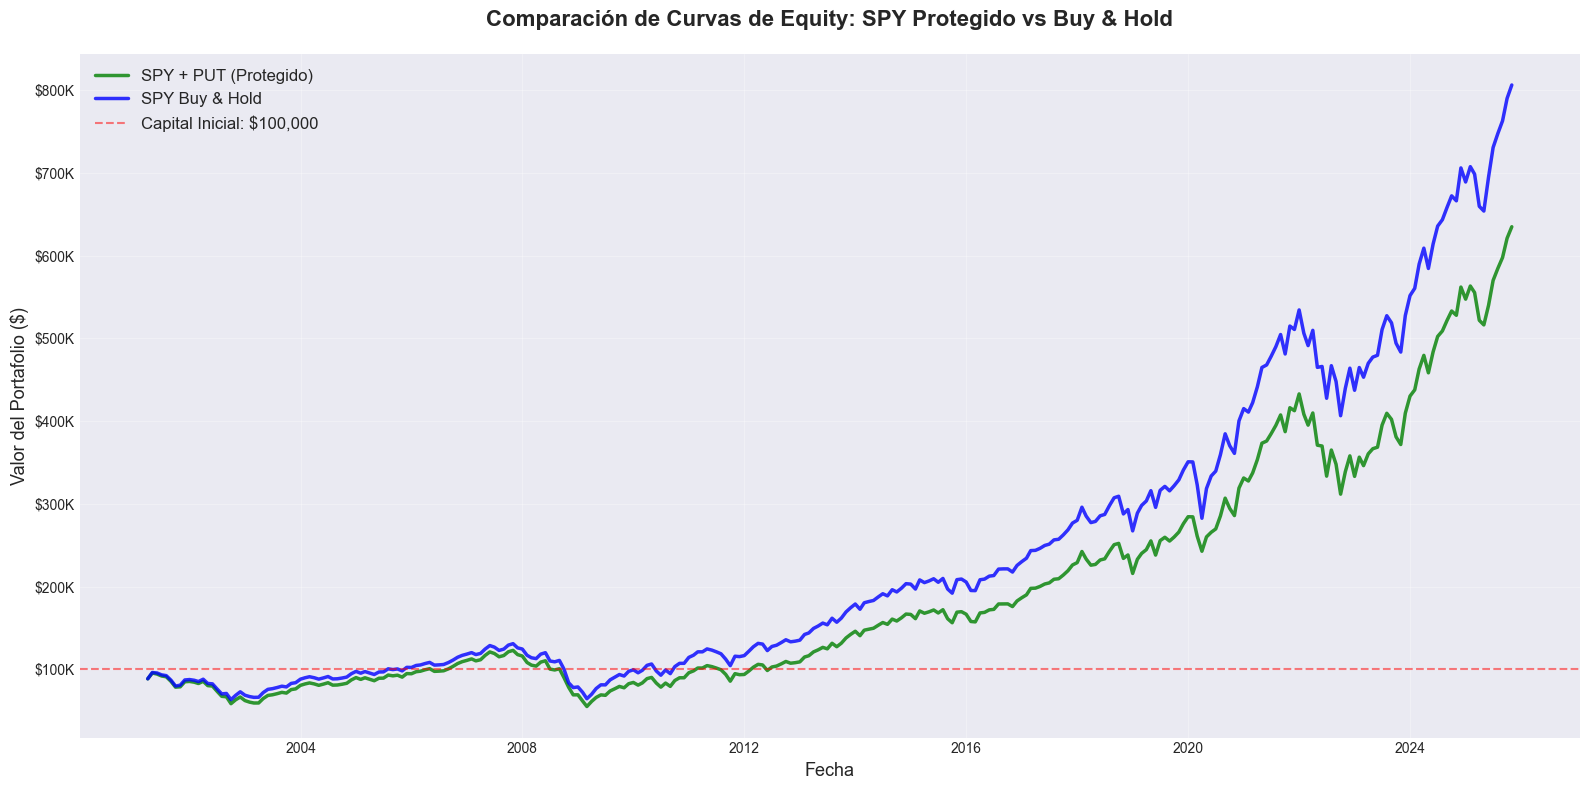

In [ ]:
# 1. Curvas de Equity Comparativas
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(comparison_df.index, comparison_df['protected'], 
        linewidth=2.5, label='SPY + PUT (Protegido)', color='green', alpha=0.8)
ax.plot(comparison_df.index, comparison_df['buy_hold'], 
        linewidth=2.5, label='SPY Buy & Hold', color='blue', alpha=0.8)
ax.axhline(y=INITIAL_CAPITAL, color='red', linestyle='--', alpha=0.5, 
           label=f'Capital Inicial: ${INITIAL_CAPITAL:,.0f}')

ax.set_title('Comparación de Curvas de Equity: SPY Protegido vs Buy & Hold', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=13)
ax.set_ylabel('Valor del Portafolio ($)', fontsize=13)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

In [ ]:
# Análisis de protección en grandes caídas mensuales
print("\n" + "="*80)
print("VERIFICACIÓN: ¿Las PUTs protegen en grandes caídas?")
print("="*80 + "\n")

# Usar los datos mensuales ya preparados (comparison_df ya tiene retornos mensuales)
# Los retornos ya están en formato decimal, convertir a porcentaje
monthly_analysis = comparison_df.copy()
monthly_analysis['protected_return_pct'] = monthly_analysis['protected_returns'] * 100
monthly_analysis['buyhold_return_pct'] = monthly_analysis['buy_hold_returns'] * 100

# Identificar meses con caídas >10% en Buy & Hold
big_drops = monthly_analysis[monthly_analysis['buyhold_return_pct'] < -10].copy()

if len(big_drops) > 0:
    print(f"Se encontraron {len(big_drops)} meses con caídas >10% en Buy & Hold:\n")
    
    for date, row in big_drops.iterrows():
        bh_return = row['buyhold_return_pct']
        protected_return = row['protected_return_pct']
        # Protección = cuánto MEJOR fue la estrategia protegida
        protection = protected_return - bh_return
        
        print(f"📅 {date.strftime('%Y-%m')}:")
        print(f"   Buy & Hold:        {bh_return:>7.2f}%")
        print(f"   Con PUT:           {protected_return:>7.2f}%")
        print(f"   Protección:        {protection:>+7.2f}% {'✓' if protection > 3 else '⚠️'}")
        print()
else:
    print("No se encontraron meses con caídas >10% en el período analizado.")

# Mostrar los 10 peores meses
print("\n" + "="*80)
print("LOS 10 PEORES MESES PARA BUY & HOLD")
print("="*80 + "\n")

worst_months = monthly_analysis.nsmallest(10, 'buyhold_return_pct')
for date, row in worst_months.iterrows():
    bh_return = row['buyhold_return_pct']
    protected_return = row['protected_return_pct']
    # Protección = cuánto MEJOR fue la estrategia protegida
    protection = protected_return - bh_return
    
    print(f"📅 {date.strftime('%Y-%m')}:")
    print(f"   Buy & Hold:   {bh_return:>7.2f}%  |  Con PUT: {protected_return:>7.2f}%  |  Protección: {protection:>+7.2f}%")

print("\n" + "="*80)



VERIFICACIÓN: ¿Las PUTs protegen en grandes caídas?

Se encontraron 4 meses con caídas >10% en Buy & Hold:

📅 2002-09:
   Buy & Hold:         -10.49%
   Con PUT:            -12.49%
   Protección:          -2.00% ⚠️

📅 2008-10:
   Buy & Hold:         -16.52%
   Con PUT:            -13.08%
   Protección:          +3.44% ✓

📅 2009-02:
   Buy & Hold:         -10.74%
   Con PUT:            -10.67%
   Protección:          +0.08% ⚠️

📅 2020-03:
   Buy & Hold:         -12.49%
   Con PUT:             -6.98%
   Protección:          +5.51% ✓


LOS 10 PEORES MESES PARA BUY & HOLD

📅 2008-10:
   Buy & Hold:    -16.52%  |  Con PUT:  -13.08%  |  Protección:   +3.44%
📅 2020-03:
   Buy & Hold:    -12.49%  |  Con PUT:   -6.98%  |  Protección:   +5.51%
📅 2009-02:
   Buy & Hold:    -10.74%  |  Con PUT:  -10.67%  |  Protección:   +0.08%
📅 2002-09:
   Buy & Hold:    -10.49%  |  Con PUT:  -12.49%  |  Protección:   -2.00%
📅 2008-09:
   Buy & Hold:     -9.42%  |  Con PUT:  -10.54%  |  Protección:   -1.12%
📅 2

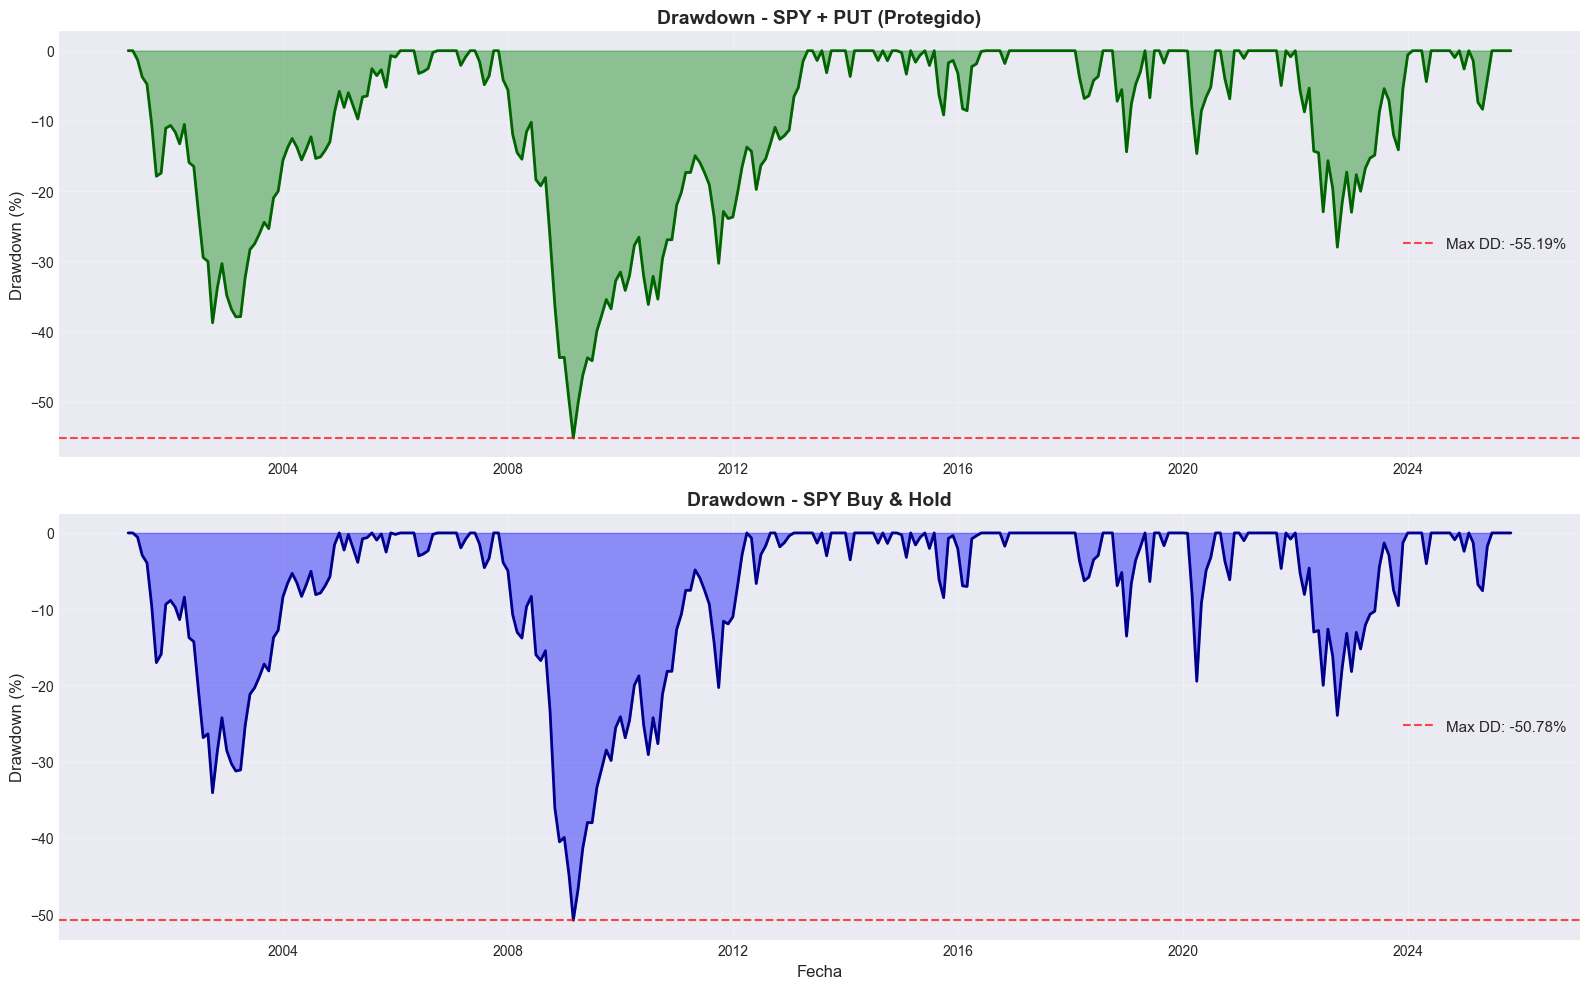

In [ ]:
# 2. Comparación de Drawdowns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Drawdown de estrategia protegida
axes[0].fill_between(protected_dd.index, protected_dd, 0, alpha=0.4, color='green')
axes[0].plot(protected_dd.index, protected_dd, linewidth=2, color='darkgreen')
axes[0].set_title('Drawdown - SPY + PUT (Protegido)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Drawdown (%)', fontsize=12)
axes[0].axhline(y=protected_metrics['Max Drawdown (%)'], color='red', linestyle='--', 
                alpha=0.7, label=f'Max DD: {protected_metrics["Max Drawdown (%)"]:.2f}%')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Drawdown de buy & hold
axes[1].fill_between(buy_hold_dd.index, buy_hold_dd, 0, alpha=0.4, color='blue')
axes[1].plot(buy_hold_dd.index, buy_hold_dd, linewidth=2, color='darkblue')
axes[1].set_title('Drawdown - SPY Buy & Hold', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].axhline(y=buy_hold_metrics['Max Drawdown (%)'], color='red', linestyle='--', 
                alpha=0.7, label=f'Max DD: {buy_hold_metrics["Max Drawdown (%)"]:.2f}%')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

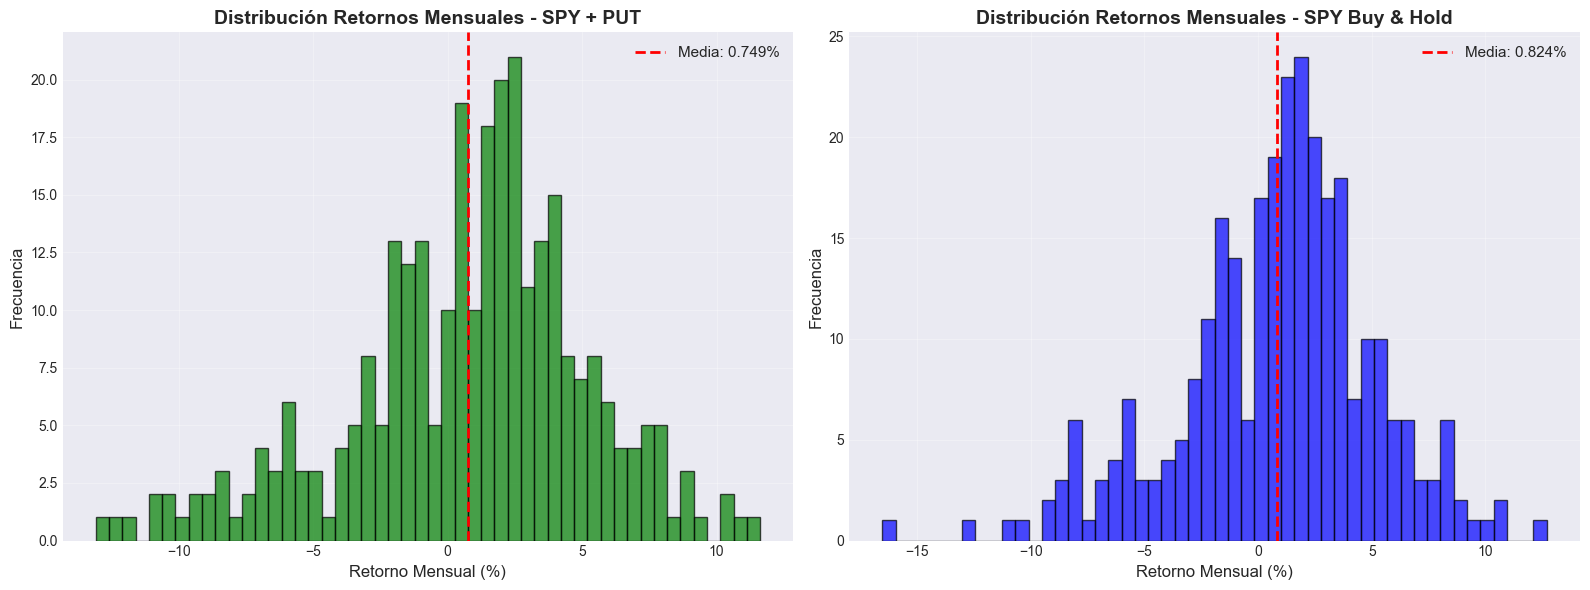


ESTADÍSTICAS DE RETORNOS DIARIOS:

SPY + PUT (Protegido):
  Media: 0.7489%
  Desv. Est.: 4.4724%
  Skewness: -0.5401
  Kurtosis: 0.4600

SPY Buy & Hold:
  Media: 0.8236%
  Desv. Est.: 4.3294%
  Skewness: -0.5326
  Kurtosis: 0.9312


In [ ]:
# 3. Distribución de Retornos Diarios
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma estrategia protegida
axes[0].hist(comparison_df['protected_returns'] * 100, bins=50, alpha=0.7, 
             color='green', edgecolor='black')
axes[0].axvline(x=comparison_df['protected_returns'].mean() * 100, color='red', 
                linestyle='--', linewidth=2, label=f'Media: {comparison_df["protected_returns"].mean()*100:.3f}%')
axes[0].set_title('Distribución Retornos Mensuales - SPY + PUT', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Retorno Mensual (%)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Histograma buy & hold
axes[1].hist(comparison_df['buy_hold_returns'] * 100, bins=50, alpha=0.7, 
             color='blue', edgecolor='black')
axes[1].axvline(x=comparison_df['buy_hold_returns'].mean() * 100, color='red', 
                linestyle='--', linewidth=2, label=f'Media: {comparison_df["buy_hold_returns"].mean()*100:.3f}%')
axes[1].set_title('Distribución Retornos Mensuales - SPY Buy & Hold', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Retorno Mensual (%)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de retornos
print("\nESTADÍSTICAS DE RETORNOS DIARIOS:")
print("="*60)
print(f"\nSPY + PUT (Protegido):")
print(f"  Media: {comparison_df['protected_returns'].mean()*100:.4f}%")
print(f"  Desv. Est.: {comparison_df['protected_returns'].std()*100:.4f}%")
print(f"  Skewness: {comparison_df['protected_returns'].skew():.4f}")
print(f"  Kurtosis: {comparison_df['protected_returns'].kurtosis():.4f}")
print(f"\nSPY Buy & Hold:")
print(f"  Media: {comparison_df['buy_hold_returns'].mean()*100:.4f}%")
print(f"  Desv. Est.: {comparison_df['buy_hold_returns'].std()*100:.4f}%")
print(f"  Skewness: {comparison_df['buy_hold_returns'].skew():.4f}")
print(f"  Kurtosis: {comparison_df['buy_hold_returns'].kurtosis():.4f}")

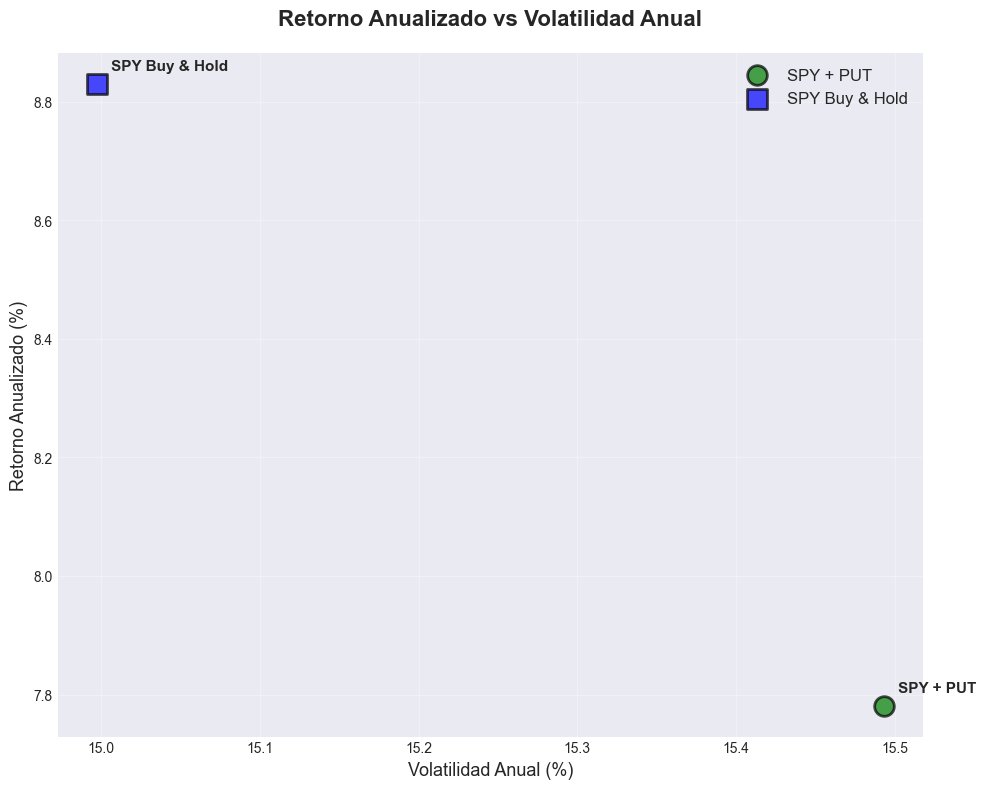

In [ ]:
# 4. Scatter Plot: Retorno vs Volatilidad
fig, ax = plt.subplots(figsize=(10, 8))

strategies_scatter = [
    {'name': 'SPY + PUT', 'return': protected_metrics['Retorno Anualizado (%)'], 
     'vol': protected_metrics['Volatilidad Anual (%)'], 'color': 'green', 'marker': 'o', 'size': 200},
    {'name': 'SPY Buy & Hold', 'return': buy_hold_metrics['Retorno Anualizado (%)'], 
     'vol': buy_hold_metrics['Volatilidad Anual (%)'], 'color': 'blue', 'marker': 's', 'size': 200}
]

for strat in strategies_scatter:
    ax.scatter(strat['vol'], strat['return'], s=strat['size'], 
              color=strat['color'], marker=strat['marker'], 
              alpha=0.7, edgecolors='black', linewidth=2, label=strat['name'])
    ax.annotate(strat['name'], (strat['vol'], strat['return']), 
               xytext=(10, 10), textcoords='offset points', fontsize=11, fontweight='bold')

ax.set_title('Retorno Anualizado vs Volatilidad Anual', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Volatilidad Anual (%)', fontsize=13)
ax.set_ylabel('Retorno Anualizado (%)', fontsize=13)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

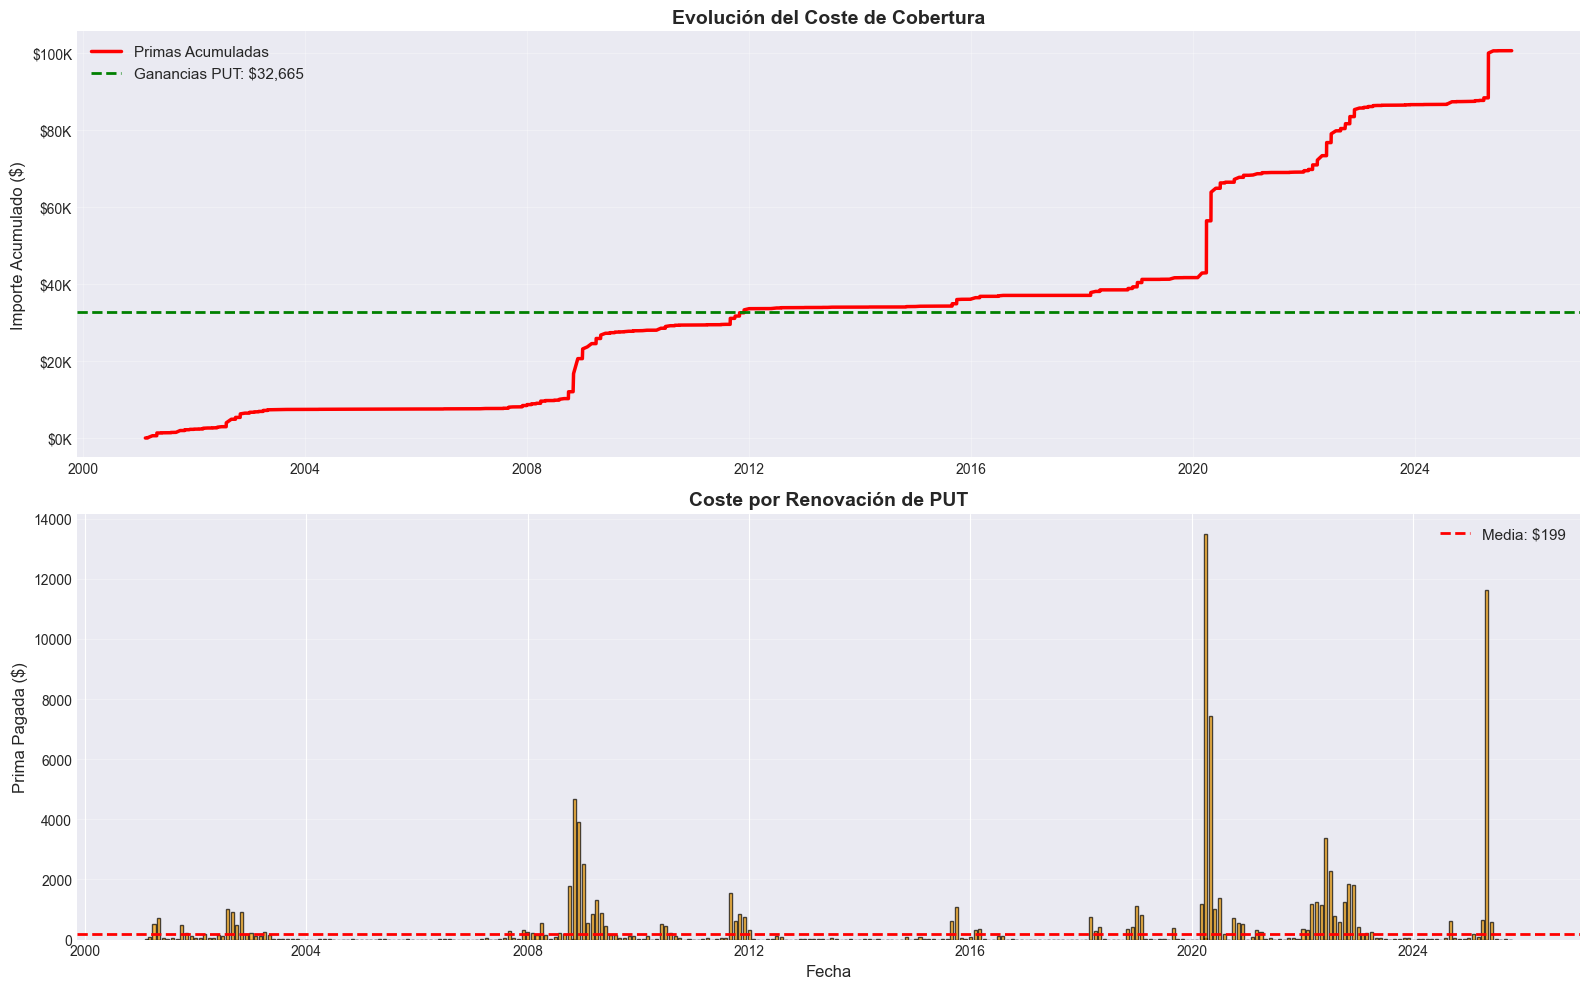


ESTADÍSTICAS DE RENOVACIONES:
  Coste promedio por renovación: $198.75
  Coste mínimo: $0.00
  Coste máximo: $13,497.57
  Desviación estándar: $949.35


In [ ]:
# 5. Evolución del Coste de Cobertura
renewals_df = pd.DataFrame(protected_strategy.put_renewals)
renewals_df['cumulative_premium'] = renewals_df['premium'].cumsum()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Primas acumuladas
axes[0].plot(renewals_df['date'], renewals_df['cumulative_premium'], 
            linewidth=2.5, color='red', label='Primas Acumuladas')
axes[0].axhline(y=protected_strategy.total_put_gains, color='green', 
               linestyle='--', linewidth=2, label=f'Ganancias PUT: ${protected_strategy.total_put_gains:,.0f}')
axes[0].set_title('Evolución del Coste de Cobertura', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Importe Acumulado ($)', fontsize=12)
axes[0].legend(fontsize=11, loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Coste por renovación
axes[1].bar(renewals_df['date'], renewals_df['premium'], 
           color='orange', alpha=0.7, edgecolor='black', width=20)
axes[1].axhline(y=renewals_df['premium'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Media: ${renewals_df["premium"].mean():,.0f}')
axes[1].set_title('Coste por Renovación de PUT', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Prima Pagada ($)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nESTADÍSTICAS DE RENOVACIONES:")
print(f"  Coste promedio por renovación: ${renewals_df['premium'].mean():,.2f}")
print(f"  Coste mínimo: ${renewals_df['premium'].min():,.2f}")
print(f"  Coste máximo: ${renewals_df['premium'].max():,.2f}")
print(f"  Desviación estándar: ${renewals_df['premium'].std():,.2f}")

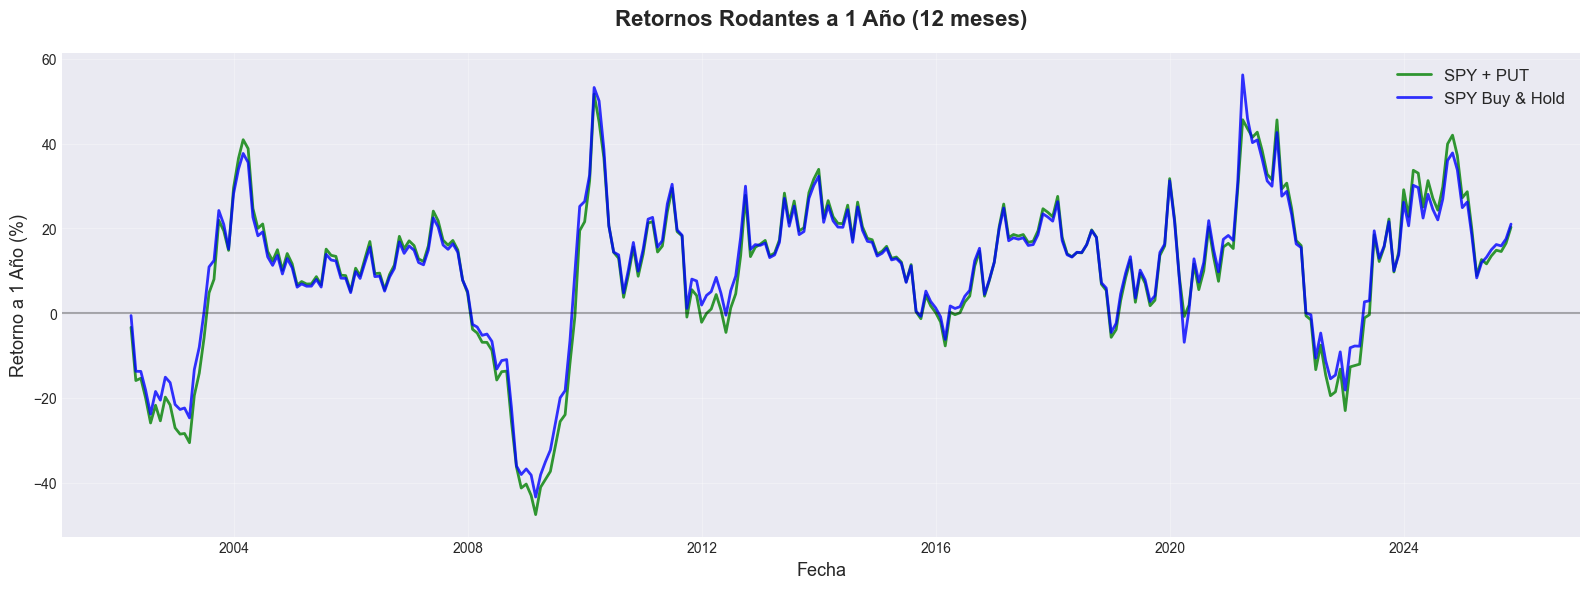

In [ ]:
# 6. Retornos Rodantes (252 días)
window = 12  # 12 meses = 1 año

protected_rolling = (comparison_df['protected'].pct_change(window).dropna() * 100)
buy_hold_rolling = (comparison_df['buy_hold'].pct_change(window).dropna() * 100)

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(protected_rolling.index, protected_rolling, 
       linewidth=2, label='SPY + PUT', color='green', alpha=0.8)
ax.plot(buy_hold_rolling.index, buy_hold_rolling, 
       linewidth=2, label='SPY Buy & Hold', color='blue', alpha=0.8)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

ax.set_title('Retornos Rodantes a 1 Año (12 meses)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=13)
ax.set_ylabel('Retorno a 1 Año (%)', fontsize=13)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Análisis de Sensibilidad

In [ ]:
# Análisis de sensibilidad: Diferentes strikes OTM
print("Ejecutando análisis de sensibilidad...\n")
print("Esto puede tomar varios minutos...\n")

otm_scenarios = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20% OTM
sensitivity_results = []

for otm in otm_scenarios:
    print(f"Probando strike {otm*100:.0f}% OTM...")
    
    strategy = ProtectedSPYStrategy(
        data=spy_data,
        initial_capital=INITIAL_CAPITAL,
        otm_percent=otm,
        days_to_expiry=DAYS_TO_EXPIRY,
        vol_adjustment=VOLATILITY_SKEW_ADJUSTMENT,
        transaction_cost_pct=TRANSACTION_COST_PCT
    )
    strategy.run()
    
    # Calcular métricas
    results_df = pd.DataFrame(strategy.portfolio_values).set_index('date')
    returns = results_df['portfolio_value'].pct_change().dropna()
    
    metrics, dd = calculate_metrics(
        returns, 
        results_df['portfolio_value'], 
        INITIAL_CAPITAL,
        f'PUT {otm*100:.0f}% OTM',
        risk_free_avg
    )
    
    metrics['Strike OTM (%)'] = otm * 100
    metrics['Primas Pagadas ($)'] = strategy.total_premiums_paid
    metrics['Ganancias PUT ($)'] = strategy.total_put_gains
    metrics['Coste Neto ($)'] = strategy.total_premiums_paid - strategy.total_put_gains
    metrics['Coste Neto (% Capital)'] = (strategy.total_premiums_paid - strategy.total_put_gains) / INITIAL_CAPITAL * 100
    
    sensitivity_results.append(metrics)
    print(f"  Retorno: {metrics['Retorno Total (%)']:.2f}%, Max DD: {metrics['Max Drawdown (%)']:.2f}%\n")

sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df = sensitivity_df.set_index('Strike OTM (%)')

print("\n" + "="*100)
print("ANÁLISIS DE SENSIBILIDAD - DIFERENTES STRIKES")
print("="*100 + "\n")
print(sensitivity_df[['Retorno Total (%)', 'Volatilidad Anual (%)', 'Max Drawdown (%)', 
                       'Sharpe Ratio', 'Coste Neto (% Capital)']].to_string())

Ejecutando análisis de sensibilidad...

Esto puede tomar varios minutos...

Probando strike 5% OTM...
Ejecutando estrategia con cobertura PUT...

Inicio: 2001-02-14
  Capital inicial: $100,000.00
  Invertido en SPY: $100,000.00 (1186.05 acciones a $84.31)
  Prima PUT pagada: $376.73
  Cash restante: $-376.73
  Valor inicial portafolio: $99,999.62


  🔔 PUT PAYOUT: 2001-02-28
     Strike: $80.10, SPY: $79.14, Caída SPY: -11.1%
     Payout: $1,141 (0.96 por acción x 1186 acciones)
     Reinvertidas 9.66 acciones a $79.14
     Total acciones ahora: 1195.71

  🔔 PUT PAYOUT: 2001-04-02
     Strike: $75.57, SPY: $73.11, Caída SPY: -12.9%
     Payout: $2,949 (2.47 por acción x 1196 acciones)
     Reinvertidas 32.67 acciones a $73.11
     Total acciones ahora: 1228.38

  🔔 PUT PAYOUT: 2001-08-31
     Strike: $74.47, SPY: $73.28, Caída SPY: -11.4%
     Payout: $1,462 (1.19 por acción x 1228 acciones)
     Reinvertidas -44.59 acciones a $73.28
     Total acciones ahora: 1183.80

  🔔 PUT PAYOUT: 


  🔔 PUT PAYOUT: 2015-08-31


     Strike: $167.54, SPY: $166.17, Caída SPY: -10.7%
     Payout: $1,124 (1.37 por acción x 820 acciones)
     Reinvertidas -45.47 acciones a $166.17
     Total acciones ahora: 774.52

  🔔 PUT PAYOUT: 2018-10-31
     Strike: $248.53, SPY: $242.69, Caída SPY: -12.1%
     Payout: $4,524 (5.84 por acción x 775 acciones)
     Reinvertidas -47.71 acciones a $242.69
     Total acciones ahora: 726.81

  🔔 PUT PAYOUT: 2018-12-31
     Strike: $237.94, SPY: $225.43, Caída SPY: -14.7%
     Payout: $9,096 (12.51 por acción x 727 acciones)
     Reinvertidas 27.26 acciones a $225.43
     Total acciones ahora: 754.07

  🔔 PUT PAYOUT: 2019-05-31
     Strike: $251.15, SPY: $249.38, Caída SPY: -10.6%
     Payout: $1,332 (1.77 por acción x 754 acciones)
     Reinvertidas -16.10 acciones a $249.38
     Total acciones ahora: 737.97

  🔔 PUT PAYOUT: 2020-03-31
     Strike: $269.87, SPY: $238.28, Caída SPY: -20.5%
     Payout: $23,311 (31.59 por acción x 738 acciones)
     Reinvertidas 70.93 acciones a $23


  🔔 PUT PAYOUT: 2020-03-31


     Strike: $255.67, SPY: $238.28, Caída SPY: -16.1%
     Payout: $17,520 (17.38 por acción x 1008 acciones)
     Reinvertidas 11.22 acciones a $238.28
     Total acciones ahora: 1019.01
✓ Backtest completado
  Total de renovaciones de PUT: 506
  Primas totales pagadas: $100,565.06
  Ganancias totales de PUT: $32,665.34
  Coste neto de cobertura: $67,899.72
  Costes de transacción: $100.57

  Valor final: $634,974.56
  Retorno total: 534.97%
  Retorno: 534.97%, Max DD: -57.61%

Probando strike 15% OTM...
Ejecutando estrategia con cobertura PUT...

Inicio: 2001-02-14
  Capital inicial: $100,000.00
  Invertido en SPY: $100,000.00 (1186.05 acciones a $84.31)
  Prima PUT pagada: $0.76
  Cash restante: $-0.76
  Valor inicial portafolio: $100,000.00




  🔔 PUT PAYOUT: 2008-10-31


     Strike: $71.97, SPY: $70.64, Caída SPY: -11.7%
     Payout: $1,576 (1.33 por acción x 1186 acciones)
     Reinvertidas -23.09 acciones a $70.64
     Total acciones ahora: 1162.96

  🔔 PUT PAYOUT: 2020-03-31
     Strike: $241.46, SPY: $238.28, Caída SPY: -11.2%
     Payout: $3,536 (3.18 por acción x 1112 acciones)
     Reinvertidas -25.29 acciones a $238.28
     Total acciones ahora: 1086.50
✓ Backtest completado
  Total de renovaciones de PUT: 506
  Primas totales pagadas: $41,354.81
  Ganancias totales de PUT: $5,479.86
  Coste neto de cobertura: $35,874.95
  Costes de transacción: $41.35

  Valor final: $713,442.35
  Retorno total: 613.44%
  Retorno: 613.44%, Max DD: -60.76%

Probando strike 20% OTM...
Ejecutando estrategia con cobertura PUT...

Inicio: 2001-02-14
  Capital inicial: $100,000.00
  Invertido en SPY: $100,000.00 (1186.05 acciones a $84.31)
  Prima PUT pagada: $0.00
  Cash restante: $-0.00
  Valor inicial portafolio: $100,000.00



✓ Backtest completado


  Total de renovaciones de PUT: 506
  Primas totales pagadas: $20,362.90
  Ganancias totales de PUT: $0.00
  Coste neto de cobertura: $20,362.90
  Costes de transacción: $20.36

  Valor final: $785,930.82
  Retorno total: 685.93%
  Retorno: 685.93%, Max DD: -59.59%


ANÁLISIS DE SENSIBILIDAD - DIFERENTES STRIKES

                Retorno Total (%)  Volatilidad Anual (%)  Max Drawdown (%)  Sharpe Ratio  Coste Neto (% Capital)
Strike OTM (%)                                                                                                  
5.0                      323.2180                 3.1665          -51.2936       -0.4287                126.9608
10.0                     534.9746                 3.7345          -57.6138       -0.3372                 67.8997
15.0                     613.4424                 3.9278          -60.7608       -0.3130                 35.8750
20.0                     685.9308                 4.0481          -59.5949       -0.2979                 20.3629


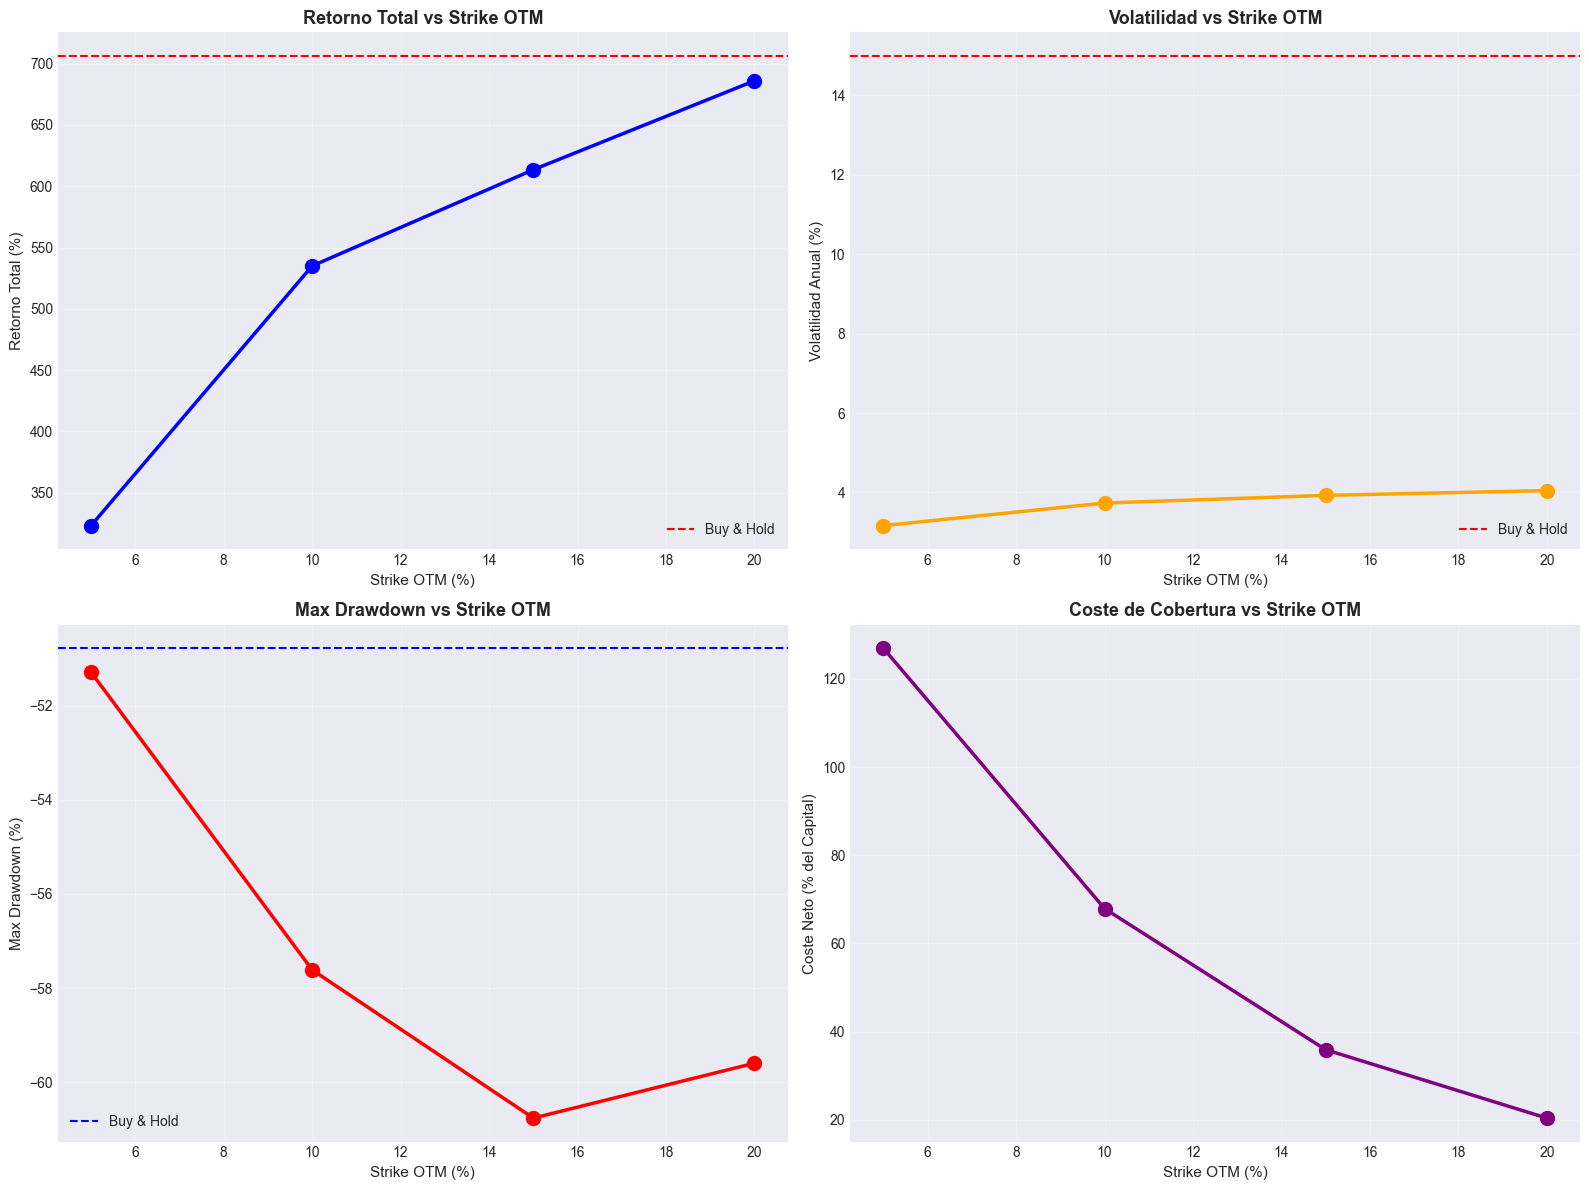

In [ ]:
# Visualizar análisis de sensibilidad
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Retorno vs Strike
axes[0, 0].plot(sensitivity_df.index, sensitivity_df['Retorno Total (%)'], 
               marker='o', linewidth=2.5, markersize=10, color='blue')
axes[0, 0].axhline(y=buy_hold_metrics['Retorno Total (%)'], color='red', 
                   linestyle='--', label='Buy & Hold')
axes[0, 0].set_title('Retorno Total vs Strike OTM', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Strike OTM (%)', fontsize=11)
axes[0, 0].set_ylabel('Retorno Total (%)', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Volatilidad vs Strike
axes[0, 1].plot(sensitivity_df.index, sensitivity_df['Volatilidad Anual (%)'], 
               marker='o', linewidth=2.5, markersize=10, color='orange')
axes[0, 1].axhline(y=buy_hold_metrics['Volatilidad Anual (%)'], color='red', 
                   linestyle='--', label='Buy & Hold')
axes[0, 1].set_title('Volatilidad vs Strike OTM', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Strike OTM (%)', fontsize=11)
axes[0, 1].set_ylabel('Volatilidad Anual (%)', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Max Drawdown vs Strike
axes[1, 0].plot(sensitivity_df.index, sensitivity_df['Max Drawdown (%)'], 
               marker='o', linewidth=2.5, markersize=10, color='red')
axes[1, 0].axhline(y=buy_hold_metrics['Max Drawdown (%)'], color='blue', 
                   linestyle='--', label='Buy & Hold')
axes[1, 0].set_title('Max Drawdown vs Strike OTM', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Strike OTM (%)', fontsize=11)
axes[1, 0].set_ylabel('Max Drawdown (%)', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Coste de Cobertura vs Strike
axes[1, 1].plot(sensitivity_df.index, sensitivity_df['Coste Neto (% Capital)'], 
               marker='o', linewidth=2.5, markersize=10, color='purple')
axes[1, 1].set_title('Coste de Cobertura vs Strike OTM', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Strike OTM (%)', fontsize=11)
axes[1, 1].set_ylabel('Coste Neto (% del Capital)', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Conclusiones y Evaluación

In [ ]:
# Resumen ejecutivo
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - ESTRATEGIA DE COBERTURA CON PUT")
print("="*80 + "\n")

# Diferencias clave
return_diff = protected_metrics['Retorno Total (%)'] - buy_hold_metrics['Retorno Total (%)']
vol_diff = protected_metrics['Volatilidad Anual (%)'] - buy_hold_metrics['Volatilidad Anual (%)']
dd_diff = protected_metrics['Max Drawdown (%)'] - buy_hold_metrics['Max Drawdown (%)']
sharpe_diff = protected_metrics['Sharpe Ratio'] - buy_hold_metrics['Sharpe Ratio']

print("1. IMPACTO EN RETORNOS:")
print(f"   - Retorno con cobertura: {protected_metrics['Retorno Total (%)']:.2f}%")
print(f"   - Retorno sin cobertura: {buy_hold_metrics['Retorno Total (%)']:.2f}%")
print(f"   - Diferencia: {return_diff:.2f}% {'(peor)' if return_diff < 0 else '(mejor)'}")
print(f"   - Coste de cobertura como % retorno: {abs(return_diff/buy_hold_metrics['Retorno Total (%)'])*100:.1f}%\n")

print("2. REDUCCIÓN DE RIESGO:")
print(f"   - Volatilidad reducida: {abs(vol_diff):.2f}% ({abs(vol_diff/buy_hold_metrics['Volatilidad Anual (%)'])*100:.1f}% menos)")
print(f"   - Max Drawdown mejorado: {abs(dd_diff):.2f}% ({abs(dd_diff/buy_hold_metrics['Max Drawdown (%)'])*100:.1f}% menos)")
print(f"   - Sharpe Ratio: {sharpe_diff:+.3f} {'(mejor)' if sharpe_diff > 0 else '(peor)'}\n")

print("3. COSTE DE LA COBERTURA:")
net_cost = protected_strategy.total_premiums_paid - protected_strategy.total_put_gains
print(f"   - Primas totales pagadas: ${protected_strategy.total_premiums_paid:,.2f}")
print(f"   - Ganancias por PUT ejercidas: ${protected_strategy.total_put_gains:,.2f}")
print(f"   - Coste neto: ${net_cost:,.2f} ({net_cost/INITIAL_CAPITAL*100:.2f}% del capital)")
print(f"   - Número de renovaciones: {len(protected_strategy.put_renewals)}")
print(f"   - Coste promedio por mes: ${net_cost / (len(spy_data)/21):,.2f}\n")

print("4. TRADE-OFF RETORNO VS RIESGO:")
if return_diff < 0 and vol_diff < 0:
    print("   ✓ La cobertura REDUCE tanto retorno como volatilidad")
    print(f"   - Por cada 1% de retorno sacrificado, se reduce {abs(vol_diff/return_diff):.2f}% de volatilidad")
    print(f"   - Por cada 1% de retorno sacrificado, se mejora {abs(dd_diff/return_diff):.2f}% el drawdown")
elif return_diff > 0 and vol_diff < 0:
    print("   ✓✓ ¡Escenario ideal! La cobertura MEJORA retorno Y REDUCE riesgo")
else:
    print("   ✗ La cobertura no ofrece beneficios claros en este período")

print("\n5. VALOR DE LA COBERTURA:")
value_add = "SÍ" if (sharpe_diff > 0 or (dd_diff > 2 and abs(return_diff) < 5)) else "NO"
print(f"   ¿Vale la pena la cobertura? {value_add}")

if value_add == "SÍ":
    print("\n   Razones:")
    if sharpe_diff > 0:
        print(f"   - Mejor Sharpe Ratio ({protected_metrics['Sharpe Ratio']:.3f} vs {buy_hold_metrics['Sharpe Ratio']:.3f})")
    if dd_diff > 2:
        print(f"   - Reducción significativa de drawdown máximo ({abs(dd_diff):.2f}%)")
    if vol_diff < -2:
        print(f"   - Notable reducción de volatilidad ({abs(vol_diff):.2f}%)")
else:
    print("\n   Razones:")
    print(f"   - Coste de cobertura ({net_cost/INITIAL_CAPITAL*100:.2f}%) supera beneficios")
    print(f"   - Período sin caídas extremas donde la PUT hubiera sido valiosa")

print("\n" + "="*80)


RESUMEN EJECUTIVO - ESTRATEGIA DE COBERTURA CON PUT

1. IMPACTO EN RETORNOS:
   - Retorno con cobertura: 534.97%
   - Retorno sin cobertura: 706.31%
   - Diferencia: -171.34% (peor)
   - Coste de cobertura como % retorno: 24.3%

2. REDUCCIÓN DE RIESGO:
   - Volatilidad reducida: 0.50% (3.3% menos)
   - Max Drawdown mejorado: 4.41% (8.7% menos)
   - Sharpe Ratio: -0.075 (peor)

3. COSTE DE LA COBERTURA:
   - Primas totales pagadas: $100,565.06
   - Ganancias por PUT ejercidas: $32,665.34
   - Coste neto: $67,899.72 (67.90% del capital)
   - Número de renovaciones: 506
   - Coste promedio por mes: $229.43

4. TRADE-OFF RETORNO VS RIESGO:
   ✗ La cobertura no ofrece beneficios claros en este período

5. VALOR DE LA COBERTURA:
   ¿Vale la pena la cobertura? NO

   Razones:
   - Coste de cobertura (67.90%) supera beneficios
   - Período sin caídas extremas donde la PUT hubiera sido valiosa



In [ ]:
# Identificar períodos donde la cobertura fue más valiosa
print("\n6. PERÍODOS DONDE LA COBERTURA FUE MÁS VALIOSA:\n")

# Encontrar los 5 mayores drawdowns del buy & hold
buy_hold_cummax = comparison_df['buy_hold'].cummax()
buy_hold_dd_pct = (comparison_df['buy_hold'] - buy_hold_cummax) / buy_hold_cummax * 100

# Encontrar fechas con drawdown > 5%
significant_dd = buy_hold_dd_pct[buy_hold_dd_pct < -5]

if len(significant_dd) > 0:
    print(f"Se identificaron {len(significant_dd)} días con drawdown > 5% en Buy & Hold:\n")
    
    # Analizar rendimiento relativo en esos períodos
    protected_performance = comparison_df.loc[significant_dd.index, 'protected']
    buyhold_performance = comparison_df.loc[significant_dd.index, 'buy_hold']
    
    outperformance = ((protected_performance - buyhold_performance) / buyhold_performance * 100).mean()
    
    print(f"Durante períodos de caídas significativas:")
    print(f"  - La estrategia protegida superó al buy & hold en promedio: {outperformance:.2f}%")
    print(f"  - Drawdown promedio Buy & Hold: {buy_hold_dd_pct[significant_dd.index].mean():.2f}%")
    
    protected_dd_pct = (comparison_df['protected'] - comparison_df['protected'].cummax()) / comparison_df['protected'].cummax() * 100
    print(f"  - Drawdown promedio Protegido: {protected_dd_pct[significant_dd.index].mean():.2f}%")
    
    # Mostrar los 5 peores días
    worst_days = buy_hold_dd_pct.nsmallest(5)
    print(f"\nLos 5 peores días para Buy & Hold:")
    for date, dd in worst_days.items():
        protected_dd_that_day = protected_dd_pct[date]
        diff = protected_dd_that_day - dd
        print(f"  {date.strftime('%Y-%m-%d')}: BH DD={dd:.2f}%, Protegido DD={protected_dd_that_day:.2f}%, Mejora={diff:.2f}%")
else:
    print("No se identificaron caídas significativas (>5%) en el período analizado.")
    print("Esto explica por qué el coste de la cobertura puede parecer alto.")


6. PERÍODOS DONDE LA COBERTURA FUE MÁS VALIOSA:

Se identificaron 123 días con drawdown > 5% en Buy & Hold:

Durante períodos de caídas significativas:
  - La estrategia protegida superó al buy & hold en promedio: -13.80%
  - Drawdown promedio Buy & Hold: -16.84%
  - Drawdown promedio Protegido: -21.78%

Los 5 peores días para Buy & Hold:
  2009-02-28: BH DD=-50.78%, Protegido DD=-55.19%, Mejora=-4.41%
  2009-03-31: BH DD=-46.68%, Protegido DD=-50.21%, Mejora=-3.53%
  2009-01-31: BH DD=-44.86%, Protegido DD=-49.84%, Mejora=-4.98%
  2009-04-30: BH DD=-41.39%, Protegido DD=-46.28%, Mejora=-4.89%
  2008-11-30: BH DD=-40.51%, Protegido DD=-43.74%, Mejora=-3.23%


In [ ]:
# Recomendaciones finales
print("\n" + "="*80)
print("RECOMENDACIONES Y PRÓXIMOS PASOS")
print("="*80 + "\n")

print("1. PERFIL DE INVERSOR ADECUADO:")
if protected_metrics['Max Drawdown (%)'] > buy_hold_metrics['Max Drawdown (%)'] * 0.7:
    print("   - Inversores con baja tolerancia al riesgo")
    print("   - Portafolios que no pueden soportar caídas > 15%")
    print("   - Inversores cerca de la jubilación (preservación de capital)")
else:
    print("   - Inversores con tolerancia media al riesgo")
    print("   - Aquellos que buscan suavizar la volatilidad sin sacrificar mucho retorno")

print("\n2. OPTIMIZACIONES POSIBLES:")
print("   - Ajustar el strike OTM según condiciones de mercado (VIX)")
print("   - Variar la frecuencia de renovación (mensual vs trimestral)")
print("   - Considerar coberturas parciales (50-75% en lugar de 100%)")
print("   - Implementar cobertura dinámica (solo cuando volatilidad es alta)")

print("\n3. LIMITACIONES DEL ANÁLISIS:")
print("   - Precios de opciones simulados con Black-Scholes (no precios reales)")
print("   - Ajuste de +20% volatilidad es estimación conservadora del skew")
print("   - No considera slippage ni impacto de mercado")
print("   - Período analizado puede no incluir crisis severas")

print("\n4. ANÁLISIS ADICIONALES RECOMENDADOS:")
print("   - Backtesting en diferentes períodos históricos (incluir 2008, 2020)")
print("   - Análisis de opciones collar (combinar PUT + CALL)")
print("   - Comparar con ETFs de baja volatilidad (ej: SPLV)")
print("   - Validar con datos reales de opciones (ej: OptionMetrics)")

print("\n" + "="*80)
print("\n✓ Análisis completado exitosamente")


RECOMENDACIONES Y PRÓXIMOS PASOS

1. PERFIL DE INVERSOR ADECUADO:
   - Inversores con tolerancia media al riesgo
   - Aquellos que buscan suavizar la volatilidad sin sacrificar mucho retorno

2. OPTIMIZACIONES POSIBLES:
   - Ajustar el strike OTM según condiciones de mercado (VIX)
   - Variar la frecuencia de renovación (mensual vs trimestral)
   - Considerar coberturas parciales (50-75% en lugar de 100%)
   - Implementar cobertura dinámica (solo cuando volatilidad es alta)

3. LIMITACIONES DEL ANÁLISIS:
   - Precios de opciones simulados con Black-Scholes (no precios reales)
   - Ajuste de +20% volatilidad es estimación conservadora del skew
   - No considera slippage ni impacto de mercado
   - Período analizado puede no incluir crisis severas

4. ANÁLISIS ADICIONALES RECOMENDADOS:
   - Backtesting en diferentes períodos históricos (incluir 2008, 2020)
   - Análisis de opciones collar (combinar PUT + CALL)
   - Comparar con ETFs de baja volatilidad (ej: SPLV)
   - Validar con datos r